# Mistral Document AI with Azure AI Foundry

Unlock high‑fidelity, layout‑aware document understanding with structured outputs. **Mistral Document AI** combines vision + language to preserve tables, figures, and headings; returns structured JSON and markdown‑like tables; and supports multilingual scans, PDFs, and complex forms. It’s sold “Direct from Azure” and deploys in one click as a serverless endpoint in **Azure AI Foundry**.

<img src="mistral-doc-structured-output.png" width=600>

- Blog: https://techcommunity.microsoft.com/blog/azure-ai-foundry-blog/deepening-our-partnership-with-mistral-ai-on-azure-ai-foundry/4434656
- Mistral AI: https://x.com/MistralAI/status/1957516008043729243

<img src="mistraldocai.png" width=600>

In [6]:
import base64
import datetime
import io
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import requests
import sys
import time

from dotenv import load_dotenv
from IPython.display import display, FileLink, Markdown
from PIL import Image
from typing import Optional, Dict, Any

In [7]:
sys.version

'3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]'

In [8]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 11-Sep-2025 17:41:50


In [9]:
# Get endpoint and key for the Mistral Document AI deployed with Azure AI Foundry
load_dotenv()

endpoint = f"{os.getenv('AZURE_OPENAI_API_ENDPOINT', '').rstrip('/')}/providers/mistral/azure/ocr"
key = os.getenv("AZURE_OPENAI_API_KEY")

In [10]:
endpoint[22:]

'urce.openai.azure.com/providers/mistral/azure/ocr'

## 1. Helper

In [11]:
def replace_images_in_md(markdown_str: str, images_dict: dict) -> str:
    """
    Replaces image links in a Markdown string with corresponding base64 image data.

    This function looks for image tags in the format:
    ![image_name](image_name)
    and replaces the URL with its base64 string from the provided dictionary.

    Args:
        markdown_str (str): The original Markdown content.
        images_dict (dict): A dictionary where keys are image names (str) and values are base64-encoded image strings.

    Returns:
        str: The Markdown content with image links replaced by base64 image strings.
    """
    for img_name, base64_str in images_dict.items():
        markdown_str = markdown_str.replace(f"![{img_name}]({img_name})",
                                            f"![{img_name}]({base64_str})")

    return markdown_str

In [12]:
def simple_combined_md(responsePage: dict) -> str:
    """
    Combines Markdown content with base64-encoded images from a response page.

    This function extracts base64 image data from the `images` section of the responsePage,
    replaces image references in the Markdown content, and returns the final combined Markdown string.

    Args:
        responsePage (dict): A dictionary with two keys:
            - "markdown" (str): The Markdown content with image placeholders.
            - "images" (list[dict]): A list of images where each image has:
                - "id" (str): The identifier used as the image filename in Markdown.
                - "image_base64" (str): The base64-encoded image string.

    Returns:
        str: The Markdown string with all image links replaced by base64 image data.
    """
    markdowns: list[str] = []
    image_data = {}

    for img in responsePage["images"]:
        image_data[img["id"]] = img["image_base64"]

    markdowns.append(replace_images_in_md(responsePage["markdown"],
                                          image_data))

    return "\n\n".join(markdowns)

In [13]:
def encode_pdf(path: str) -> str:
    """
    Encodes a file into a base64 string.
    
    Args:
        path (str): The file path.

    Returns:
        str: Base64-encoded string of the file.
    """
    with open(path, "rb") as file:
        return base64.b64encode(file.read()).decode("utf-8")

In [14]:
def mistral_document_ai(pdf_path: str) -> dict:
    """
    Encodes a PDF file and sends it to the Mistral Document AI API for processing.

    This function reads the PDF file from the specified `pdf_path`, encodes it in base64,
    and sends it to the Mistral Document AI API with the necessary headers and payload.

    Args:
        pdf_path (str): The path to the PDF file to be processed.

    Returns:
        dict: Parsed JSON response from the API. If the request fails, `None` is returned.
    """
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {key}",
    }

    try:
        encoded_document = encode_pdf(pdf_path)

        document_payload = {
            "model": "mistral-document-ai-2505",
            "document": {
                "type": "document_url",
                "document_url":
                f"data:application/pdf;base64,{encoded_document}",
            },
        }

        response = requests.post(
            url=endpoint,
            json=document_payload,
            headers=headers,
        )
        response.raise_for_status()
        print(f"✅ OK")
        return response.json()

    except requests.exceptions.RequestException as e:
        print(f"❌ HTTP request failed: {e}")
        return None

    except Exception as e:
        print(f"❌ Error: {e}")
        return None

In [15]:
def mistral_document_ai_images(pdf_path: str) -> dict:
    """
    Encodes a PDF file and sends it to the Mistral Document AI API for processing, including image extraction.

    This function reads a PDF file from the specified `pdf_path`, encodes it into base64 format, 
    and sends it to the Mistral Document AI API along with an option to include image data
    from the document in the response.

    Args:
        pdf_path (str): The path to the PDF file that will be processed.

    Returns:
        dict: The JSON response parsed from the API. If the request fails, `None` is returned.
    """
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {key}",
    }

    try:
        encoded_document = encode_pdf(pdf_path)

        documentPayloadandImages = {
            "model":"mistral-document-ai-2505",  # Model ID for the Mistral Document AI
            "document": {
                "type": "document_url",
                "document_url": f"data:application/pdf;base64,{encoded_document}",
            },
            "include_image_base64":"true",  # Indicates to include images in base64 format
        }

        # Sending the POST request to the API
        response = requests.post(
            url=endpoint,
            json=documentPayloadandImages,
            headers=headers,
        )

        response.raise_for_status() 
        print(f"✅ OK")
        return response.json()

    except requests.exceptions.RequestException as e:
        print(f"❌ HTTP request failed: {e}")
        return None

    except Exception as e:
        print(f"❌ Error: {e}")
        return None

In [16]:
def view_doc_images(document_data: str):
    """
    Extracts and visually displays all base64-encoded images from a structured document.

    Parameters:
    ----------
    document_data : dict
        A dictionary containing document content, expected to include a 'pages' key.
        Each page may contain an 'images' list, where each image entry includes:
        - 'id': Unique identifier for the image.
        - 'image_base64': Base64-encoded image string (may include a data URL prefix).
        - 'top_left_x', 'top_left_y': Coordinates of the image's top-left corner.
        - 'bottom_right_x', 'bottom_right_y': Coordinates of the image's bottom-right corner.

    Behavior:
    --------
    - Iterates through each page and image in the document.
    - Decodes base64 image data and renders it using matplotlib.
    - Displays image metadata including dimensions and position.
    - Prints visual and positional details for each image.

    Returns:
    -------
    None
        This function displays images and prints metadata but does not return any value.
    """
    pages = document_data['pages']

    for page_idx, page in enumerate(pages):
        if 'images' in page and page['images']:
            print(f"Page {page_idx + 1} has {len(page['images'])} image(s)")

            for img_idx, image_info in enumerate(page['images']):
                img_id = image_info['id']
                base64_data = image_info['image_base64']

                if base64_data.startswith('data:image'):
                    base64_data = base64_data.split(',')[1]

                image = Image.open(io.BytesIO(base64.b64decode(base64_data)))

                plt.figure(figsize=(15, 8))
                plt.imshow(image)
                plt.title(f"Page {page_idx + 1}, Image {img_idx + 1}: {img_id}\n")
                plt.axis('off')
                plt.show()

                print(f"🖼️ Image dimensions: {image.size}")
                print(f"📍 Position: top-left ({image_info['top_left_x']}, {image_info['top_left_y']})")
                print(f"📍 Position: bottom-right ({image_info['bottom_right_x']}, {image_info['bottom_right_y']})")
                print()
                print()

In [17]:
def save_base64_image(base64_string: str, filename: str):
    """
    Decodes a base64-encoded image string and saves it to disk using the specified filename.

    Parameters:
    ----------
    base64_string : str
        A base64-encoded string representing the image. May optionally include a data URL prefix (e.g., 'data:image/png;base64,...').

    filename : str
        The full path (including filename) where the image will be saved.

    Returns:
    -------
    PIL.Image.Image
        The image object that was saved.

    Side Effects:
    ------------
    - Saves the decoded image to the specified file path.
    - Prints a confirmation message with the saved filename.
    """
    if base64_string.startswith('data:image'):
        base64_string = base64_string.split(',')[1]

    image = Image.open(io.BytesIO(base64.b64decode(base64_string)))
    image.save(filename)
    print(f"💾 Saved image as {filename}")
    return image

In [18]:
def extract_and_save_images(document_data: str,
                                output_dir="extracted_images"):
    """
    Extracts all base64-encoded images from a structured document and saves them to disk.

    Parameters:
    ----------
    document_data : dict
        A dictionary containing document content, expected to have a 'pages' key.
        Each page should include an 'images' list with image metadata including 'id' and 'image_base64'.

    output_dir : str, optional
        Directory where extracted images will be saved. Defaults to 'extracted_images'.
        The directory will be created if it does not exist.

    Returns:
    -------
    list of str
        A list of file paths for the saved images.

    Side Effects:
    ------------
    - Creates the output directory if it doesn't exist.
    - Saves each image as a file in the specified directory.
    - Prints the total number of images extracted.
    """
    os.makedirs(output_dir, exist_ok=True)

    pages = document_data['pages']
    image_count = 0
    filenames_list = []

    for page_idx, page in enumerate(pages):
        if 'images' in page and page['images']:
            for img_idx, image_info in enumerate(page['images']):
                img_id = image_info['id']
                base64_data = image_info['image_base64']
                
                filename = os.path.join(output_dir, f"image_from_page_{page_idx+1:05}_{img_id}")
                filenames_list.append(filename)
                save_base64_image(base64_data, filename)
                image_count += 1

    print(f"\nTotal of extracted images = {image_count}")
    return filenames_list

In [19]:
def display_images(directory_path, image_files, max_images=None, cols=3):
    """
    Display all images from a specified directory
    
    Args:
        directory_path (str): Path to the directory containing images
        image_files (str): Images list
        max_images (int): Maximum number of images to display (None for all)
        cols (int): Number of columns in the display grid
    """   
    if max_images:
        image_files = image_files[:max_images]
    
    print(f"Number of images = {len(image_files)}")
    
    rows = (len(image_files) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))

    if len(image_files) == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, img_path in enumerate(image_files):
        try:
            img = mpimg.imread(img_path)
            axes[i].imshow(img)
            axes[i].set_title(os.path.basename(img_path), fontsize=12)
            axes[i].axis('off')
            
        except Exception as e:
            print(f"❌ Error loading {img_path}: {e}")
            axes[i].text(0.5, 0.5, f"Error loading\n{os.path.basename(img_path)}", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    for i in range(len(image_files), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

## 2. OCR from text

In [20]:
pdf_file = "document.pdf"

In [21]:
!ls $pdf_file -lh

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [22]:
file_link = FileLink(path=pdf_file)
file_link

c:\Users\gugregor\OneDrive\Scripts\Python\GreyMatter\document.pdf

In [23]:
start = time.time()

print(f"🧠 Analyzing file {pdf_file} ...")
results = mistral_document_ai(pdf_file)

elapsed = time.time() - start
print(f"\nDone in {elapsed:.2f} seconds")

🧠 Analyzing file document.pdf ...
✅ OK

Done in 14.91 seconds


In [24]:
print("\033[1;31;34m")
print(json.dumps(results, indent=5))


{
     "pages": [
          {
               "index": 0,
               "images": [
                    {
                         "id": "img-0.jpeg",
                         "top_left_x": 860,
                         "top_left_y": 580,
                         "bottom_right_x": 1513,
                         "bottom_right_y": 1038,
                         "image_base64": null,
                         "image_annotation": null
                    }
               ],
               "markdown": "# Florence: A New Foundation Model for Computer Vision \n\nLu Yuan ${ }^{1}$ Dongdong Chen ${ }^{* 1}$ Yi-Ling Chen ${ }^{* 1}$ Noel Codella ${ }^{* 1}$ Xiyang Dai ${ }^{* 1}$ Jianfeng Gao ${ }^{* 2}$ Houdong Hu ${ }^{* 1}$<br>Xuedong Huang ${ }^{* 1}$ Boxin Li ${ }^{* 1}$ Chunyuan Li ${ }^{* 2}$ Ce Liu ${ }^{* 1}$ Mengchen Liu ${ }^{* 1}$ Zicheng Liu ${ }^{* 1}$ Yumao Lu ${ }^{* 1}$<br>Yu Shi ${ }^{* 1}$ Lijuan Wang ${ }^{* 1}$ Jianfeng Wang ${ }^{* 1}$ Bin Xiao ${ }^{* 1}$ Zhen Xiao ${ }^{*

### Text from page 1

In [25]:
# Page 1

print("\033[1;31;34m")
print(results["pages"][0]["markdown"])


# Florence: A New Foundation Model for Computer Vision 

Lu Yuan ${ }^{1}$ Dongdong Chen ${ }^{* 1}$ Yi-Ling Chen ${ }^{* 1}$ Noel Codella ${ }^{* 1}$ Xiyang Dai ${ }^{* 1}$ Jianfeng Gao ${ }^{* 2}$ Houdong Hu ${ }^{* 1}$<br>Xuedong Huang ${ }^{* 1}$ Boxin Li ${ }^{* 1}$ Chunyuan Li ${ }^{* 2}$ Ce Liu ${ }^{* 1}$ Mengchen Liu ${ }^{* 1}$ Zicheng Liu ${ }^{* 1}$ Yumao Lu ${ }^{* 1}$<br>Yu Shi ${ }^{* 1}$ Lijuan Wang ${ }^{* 1}$ Jianfeng Wang ${ }^{* 1}$ Bin Xiao ${ }^{* 1}$ Zhen Xiao ${ }^{* 1}$ Jianwei Yang ${ }^{* 2}$ Michael Zeng ${ }^{* 1}$<br>Luowei Zhou ${ }^{* 1}$ Pengchuan Zhang ${ }^{* 2}$<br>\section*{Abstract}

Automated visual understanding of our diverse and open world demands computer vision models to generalize well with minimal customization for specific tasks, similar to human vision. Computer vision foundation models, which are trained on diverse, large-scale dataset and can be adapted to a wide range of downstream tasks, are critical for this mission to solve real-wo

### Markdown extraction for all pages

In [26]:
print(f"Number of pages = {len(results['pages'])}")

Number of pages = 17


### Let's display only some pages

In [27]:
for i in range(4):
    display(Markdown(results["pages"][i]["markdown"]))

# Florence: A New Foundation Model for Computer Vision 

Lu Yuan ${ }^{1}$ Dongdong Chen ${ }^{* 1}$ Yi-Ling Chen ${ }^{* 1}$ Noel Codella ${ }^{* 1}$ Xiyang Dai ${ }^{* 1}$ Jianfeng Gao ${ }^{* 2}$ Houdong Hu ${ }^{* 1}$<br>Xuedong Huang ${ }^{* 1}$ Boxin Li ${ }^{* 1}$ Chunyuan Li ${ }^{* 2}$ Ce Liu ${ }^{* 1}$ Mengchen Liu ${ }^{* 1}$ Zicheng Liu ${ }^{* 1}$ Yumao Lu ${ }^{* 1}$<br>Yu Shi ${ }^{* 1}$ Lijuan Wang ${ }^{* 1}$ Jianfeng Wang ${ }^{* 1}$ Bin Xiao ${ }^{* 1}$ Zhen Xiao ${ }^{* 1}$ Jianwei Yang ${ }^{* 2}$ Michael Zeng ${ }^{* 1}$<br>Luowei Zhou ${ }^{* 1}$ Pengchuan Zhang ${ }^{* 2}$<br>\section*{Abstract}

Automated visual understanding of our diverse and open world demands computer vision models to generalize well with minimal customization for specific tasks, similar to human vision. Computer vision foundation models, which are trained on diverse, large-scale dataset and can be adapted to a wide range of downstream tasks, are critical for this mission to solve real-world computer vision applications. While existing vision foundation models such as CLIP (Radford et al., 2021), ALIGN (Jia et al., 2021), and Wu Dao 2.0 (Wud) focus mainly on mapping images and textual representations to a cross-modal shared representation, we introduce a new computer vision foundation model, Florence, to expand the representations from coarse (scene) to fine (object), from static (images) to dynamic (videos), and from RGB to multiple modalities (caption, depth). By incorporating universal visual-language representations from Web-scale image-text data, our Florence model can be easily adapted for various computer vision tasks, such as classification, retrieval, object detection, VQA, image caption, video retrieval and action recognition. Moreover, Florence demonstrates outstanding performance in many types of transfer learning: fully sampled fine-tuning, linear probing, few-shot transfer and zero-shot transfer for novel images and objects. All of these properties are critical for our vision foundation model to serve general purpose vision tasks. Florence achieves new state-of-the-art results in majority of 44 representative benchmarks, e.g. ImageNet-1K zero-shot classification with top-1 accuracy of 83.74 and the top-5 accuracy of $97.18,62.4 \mathrm{mAP}$ on COCO fine tuning, 80.36 on VQA, and 87.8 on Kinetics-600.

[^0]![img-0.jpeg](img-0.jpeg)

Figure 1. Common computer vision tasks are mapped to a Space-Time-Modality space. A computer vision foundation model should serve as general purpose vision system for all of these tasks.

## 1. Introduction

Human-like AI is not achieved by designing specific models to solve specific problems, but by holistic, joint models that can simultaneously solve diverse, real-world problems without too much human involvement. It is thus desirable to have new AI architectures that learn joint, fundamental representations to support a broad range of downstream AI tasks with limited additional domain knowledge, similar to what humans would do. One such proposal is XYZcode (Huang), where monolingual text (X), audio and visual sensory signals (Y), and multilingual (Z) are organically integrated to create AI models that can speak, hear, see, and understand. Another approach is Pathways (Dean), a single model that can generalize across millions of tasks.

A concrete step towards this direction is the development of foundation models. The term of foundation model was first introduced in (Bommasani et al., 2021) to refer to any model that is trained from broad data at scale that is capable of being adapted (e.g. fine-tuned) to a wide range of downstream tasks. Foundation models become promising due to their impressive performance and generalization capabilities.


[^0]:    *Florence Team member in alphabetic order ${ }^{1}$ Microsoft Cloud and AI ${ }^{2}$ Microsoft Research Redmond. Correspondence to: Lu Yuan $<$ luyuan@microsoft.com>.

![img-1.jpeg](img-1.jpeg)

Figure 2. Overview of building Florence. Our workflow consists of data curation, unified learning, Transformer architectures and adaption. It shows the foundation model can be adapted to various downstream tasks and finally integrated into modern computer vision system to power real-world vision and multimedia applications. Compared with existing image-text pretraining models (Radford et al., 2021; Jia et al., 2021; Wud), mainly limited on cross-modal shared representation for classification and retrieval (illustrated by light-green adaptation module), Florence expands the representation to support object level, multiple modality, and videos respectively.

They are quickly integrated and deployed into real-world AI systems by many researchers and developers.

Although foundation models have already demonstrated huge impact in NLP, e.g., BERT (Devlin et al., 2019), GPT-3 (Brown et al., 2020), in computer vision it is still standard practice to pre-train models on labeled data sets such as ImageNet (Deng et al., 2009). More recently, large-scale pre-training methods such as CLIP (Radford et al., 2021), ALIGN (Jia et al., 2021), and Wu Dao 2.0 (Wud), which learn directly from Web-scale image-text pairs, show very encouraging progress for efficient transfer learning, and zero-shot capability. However, such models are restricted to image to text mapping only tasks such as classification, retrieval, and tagging.

We raise the question: "What is the foundation model for computer vision?". But first, in order to better define what "foundation" means in computer vision, we capture the spectrum of tasks in a problem space (Figure 1) with three orthogonal axes: 1) Space: from coarse (e.g. scene-level classification) to fine-grained (e.g. object detection), 2) Time: from static (e.g. images) to dynamic (e.g. videos), and 3) Modality: from RGB only to multiple senses (e.g. captioning and depth). Due to the diversity nature of visual understanding, we redefine foundation models for computer vision to be a pre-trained model and its adapters for solving all vision tasks in this Space-Time-Modality space, with transferability such as zero-/few-shot learning and fully fine tuning, etc. The adaptation for transferability is restricted to minimum customization for the pre-trained foundation models, such as continuing training, few epochs or few layers for fine tuning without significantly increasing or changing model parameters.

In this paper, we present an emerging paradigm for building a vision foundation model, called Florence. We use the name of Florence as the origin of the trail for exploring vision foundation models, as well as the birthplace of Renaissance. Florence is trained on noisy Web-scale data end-to-end with a unifying objective, allowing the model to achieve best-in-class performance across a wide range of benchmarks.

The ecosystem of constructing Florence consists of data curation, model pretraining, task adaptations and training infrastructure, as shown in Figure 2.

- Data curation. Diverse, large-scale data is the lifeblood of foundation models. Enabled by large amounts of publicly available images on the Internet with natural language weak supervision, we curate a new dataset of 900 million image-text pairs for training. As Web-crawled data is usually noisy free-form texts (e.g., word, phrase or sentence), to attain more effective learning, we consider UniCL, a unified image-text contrastive learning objective recently proposed in (Yang et al., 2022), which has demonstrated improvements over contrastive and supervised learning approaches.
- Model pretraining (representation learning). To learn a good representation from image-text pairs, we used a

two-tower architecture including an image encoder and a language encoder, as commonly used in CLIP (Radford et al., 2021) and ALIGN (Jia et al., 2021). For the image encoder, we chose hierarchical Vision Transformers (e.g. , Swin (Liu et al., 2021a), CvT (Wu et al., 2021), Vision Longformer (Zhang et al., 2021a), Focal Transformer (Yang et al., 2021), and CSwin (Dong et al., 2021)). While inheriting performance benefits of the transformer self-attention operations (Dosovitskiy et al., 2021b), these hierarchical architectures model the scale invariance nature of images and have linear computational complexity with respect to image size, a property that is essential to dense prediction tasks such as object detection and segmentation.

- Task adaptations. As we have defined computer vision foundation models to adapt to various downstream tasks, it is vital for Florence to be extensible and transferable for this purpose. We extended the learned feature representation along space (from scene to objects) using the dynamic head adapter (Dai et al., 2021a), time (from static image to videos) via proposed video CoSwin adapter, and modality (from images to language) via METER adapter (Dou et al., 2021). Florence is designed to effectively adapted in the open world via few-shot and zero-shot transfer learning, with the ability of efficient deployment by extra training with few epochs (e.g. in retrieval). Our model can be customized for various domains that applicationdevelopers can use.
- Training infrastructure. For both energy and cost concerns, it is critical to build foundation models with as low cost as possible. We developed scalable training infrastructure to improve training efficiency. It consists of several key techniques such as ZeRO (Rajbhandari et al., 2019), activation checkpointing, mixed-precision training, gradient cache (Gao et al., 2021) to greatly reduce the memory consumption and thus improves the training throughput.

Florence significantly outperforms previous large-scale pretraining methods and achieves new state-of-the-art results on a wide range of vision and vision-language benchmarks. It showed strength in zero-shot transfer in 12 classification downstream tasks (win 9/12, SOTA in ImageNet-1K zeroshot with top-1 accuracy of 83.74 and the top-5 accuracy of 97.18), linear probe in 11 classification downstream tasks (win 9/11), image retrieval zero-shot (90.9/76.7 R@1 on Flickr30K image-to-text / text-to-image, 64.7/47.2 R@1 on MSCOCO image-to-text / text-to-image) and fine-tuning (97.2/87.9 R@1 on Flickr30K image-to-text / text-to-image, 81.8/63.2 R@1 on MSCOCO image-to-text/ text-to-image), object detection ( 62.4 mAP on COCO, 39.3 mAP on Object365, 16.2 AP50 on Visual Genome), VQA (80.36),
text-to-video retrieval zero-shot (37.6 R@1 on MSR-VTT), and video action recognition (top-1 accuracy 86.5/87.8 on Kinetics-400 / Kinetics-600).

## 2. Approach

### 2.1. Dataset Curation

We leverage large quantities of image-text data available publicly on the internet. Specifically, we construct a 900 million image-text-pair dataset, called FLD-900M (FLD stands for FLorenceDataset), using a programmatic data curation pipeline that processes around 3 billion Internet images and their raw descriptions in parallel. Selection and post-filtering is employed to ensure data relevance and quality while respecting legal and ethical constraints. To improve data quality, we performed rigorous data filtering, similar to ALIGN (Jia et al., 2021), including a simple hash-based near-duplicate image removal, small-size image removal, image-text relevance, etc. In addition, we follow the sampling strategy introduced in (Radford et al., 2021; Ramesh et al., 2021) with the goal of achieving improved balance, informativeness, and learnability of the sampled dataset. The final form of the FLD-900M dataset consists of 900 M images with 900 M free-form texts (ranging from one word, phase to sentences), 9.7 M unique queries, and $7.5 B$ tokens in total.

### 2.2. Unified Image-Text Contrastive Learning

CLIP (Radford et al., 2021) implicitly assumes that each image-text pair has its unique caption, which allows other captions to be considered negative examples. However, in web-scale data, multiple images can be associated with identical captions. For example, in FLD-900M, there are $350 M$ image-text pairs where there are more than one images corresponding to one identical text, and all images associated with the same text can be treated as positive pairs in contrastive learning.

To address this issue, we utilize a unified image-text contrastive learning (UniCL) (Yang et al., 2022), where Florence is pre-trained in an image-label-description space. Given an image-text pair, we generate a triplet $(\boldsymbol{x}, \boldsymbol{t}, \boldsymbol{y})$ via a text hash-table, where $\boldsymbol{x}$ is the image, $\boldsymbol{t}$ is the language description (i.e., hash value), and $\boldsymbol{y}$ is the language label (i.e., hash key) indicating the index of unique language description in the dataset. Note that we only map identical language description to the same hash key, i.e., language label. Thus, all image-text pairs mapped to the same label $\boldsymbol{y}$ are regarded as positive in our universal image-text contrastive learning. Others are still regarded as negative. The unified learning objective in the common image-labeldescription space unifies two popular learning paradigms - mapping images to the label for learning discriminative

representations (i.e. , supervised learning) and assigning each description with a unique label for language-image pre-training (i.e. , contrastive learning).

Our empirical experiments indicate that long language descriptions with rich content would be more beneficial for image-text representation learning than short descriptions (e.g. , one or two words). We have to enrich the short description by generating prompt templates such as "A photo of the [WORD]", "A cropped photo of [WORD]", as data augmentation. During training, we randomly select one template to generate $\boldsymbol{t}$ for each short language description.

Following UniCL *(Yang et al., 2022)*, we denote $f_{\theta}$ and $f_{\phi}$ as the image encoder and text encoder, respectively. $\boldsymbol{u}$ and $\boldsymbol{v}$ are the normalized visual feature vector and language feature vector, respectively, where $\boldsymbol{u}=\frac{f_{\phi}(\boldsymbol{x})}{\left\|f_{\phi}(\boldsymbol{x})\right\|}$, and $\boldsymbol{v}=$ $\frac{f_{\phi}(\boldsymbol{t})}{\left\|f_{\phi}(\boldsymbol{t})\right\|}$. $\tau$ is a learnable temperature. Given a mini-batch $\mathcal{B}$, we use a bi-directional supervised contrastive learning objective between images and language descriptions to train the model as:

$$
\mathcal{L}=\mathcal{L}_{i 2 t}+\mathcal{L}_{t 2 i}
$$

This objective contains two contrastive terms: the supervised image-to-language contrastive loss

$$
\mathcal{L}_{i 2 t}=-\sum_{i \in \mathcal{B}} \frac{1}{|\mathcal{P}(i)|} \sum_{k \in \mathcal{P}(i)} \log \frac{\exp \left(\tau \boldsymbol{u}_{i} \boldsymbol{v}_{k}\right)}{\sum_{j \in \mathcal{B}} \exp \left(\tau \boldsymbol{u}_{i} \boldsymbol{v}_{j}\right)}
$$

where $k \in \mathcal{P}(i)=\left\{k \mid k \in \mathcal{B}, y_{k}=y_{i}\right\}$, and the supervised language-to-image contrastive loss

$$
\mathcal{L}_{t 2 i}=-\sum_{j \in \mathcal{B}} \frac{1}{|\mathcal{Q}(j)|} \sum_{k \in \mathcal{Q}(j)} \log \frac{\exp \left(\tau \boldsymbol{u}_{k} \boldsymbol{v}_{j}\right)}{\sum_{i \in \mathcal{B}} \exp \left(\tau \boldsymbol{u}_{i} \boldsymbol{v}_{j}\right)}
$$

where $k \in \mathcal{Q}(j)=\left\{k \mid k \in \mathcal{B}, y_{k}=y_{j}\right\}$.
The generated language prompt is not a precise description of an image, typically not as informative as the associated text descriptions from the Internet. Although including generated language prompt might not affect classification accuracy, it hurts the performance in retrieval and visionlanguage tasks. To mitigate the negative effect from augmented prompts, our training is separated into two stages. In the first stage, we use all data including augmented texts for training; while in the second stage, we exclude all augmented data for continuing training. We trained $1 M$ iterations in the first stage, and continuously trained $180 K$ iterations in the second stage. The Adam optimizer with decoupled weight decay regularization is utilized for model training. The image size is $224 \times 224$ and the maximum language description length is truncated at 76 . The batch size is 24,576 . We further trained $80 K$ iterations at a higher resolution of $384 \times 384$ to boost the performance, which follows existing pre-training approaches.

### 2.3. Transformer-based Florence Pretrained Models

Our Florence pretrained model uses a two-tower architecture: a 12-layer transformer *(Vaswani et al., 2017)* as language encoder, similar to CLIP *(Radford et al., 2021)*, and a hierarchical Vision Transformer as the image encoder. The hierarchical Vision Transformer is a modified Swin Transformer *(Liu et al., 2021a)* with convolutional embedding, called CoSwin Transformer. Specifically, we replace the patch embedding and patch merging modules in the Swin Transformer *(Liu et al., 2021a)* with the convolutional embedding layers as described in CvT *(Wu et al., 2021)*. We use the CoSwin Transformer with global average pooling to extract image features. Two linear projection layers are added on top of the image encoder and language encoder to match the dimensions of image and language features. Our Florence pretrained model has in total $893 M$ parameters, including the language transformer with $256 M$ parameters and the CoSwin-H transformer with $637 M$ parameters. The model takes 10 days to train on 512 NVIDIA-A100 GPUs with 40GB memory per GPU.

### 2.4. Object-level Visual Representation Learning

We extend the Florence pretrained model to learn finegrained (i.e. , object-level) representation, which is fundamental to dense prediction tasks such as object detection. For this goal, we add an adaptor Dynamic Head *(Dai et al., 2021a)* (or Dynamic DETR *(Dai et al., 2021b)*), a unified attention mechanism for the detection head, to the pretrained image encoder (i.e. , CoSwin). We can continue visual representation learning from coarse (scene) to fine (object).

Based on the hierarchical structure of the image encoder CoSwin-H, we can get the output feature pyramids from the different scale levels. The feature pyramid scale levels can be concatenated and scaled-down or scaled-up into a 3-dimensional tensor with dimensions level $\times$ space $\times$ channel. The key idea of Dynamic Head *(Dai et al., 2021a)* is to deploy three attention mechanisms, each on one of the orthogonal dimensions of the tensor, i.e., level-wise, spatialwise, and channel-wise. Compared with building a single self-attention mechanism over this tensor, Dynamic Head makes the computation more affordable and enables more efficient learning. The above three attention mechanisms are applied sequentially, and we can effectively stack multiple blocks consisting of such three attention layers together. Figure 3 shows the Dynamic Head building blocks. In this work, Dynamic Head is trained with the one-stage ATSS framework and losses.

We have constructed a large-scale object detection dataset, called FLOD-9M (for FLorence Object detection Dataset), for object detection pre-training. We merge several wellknown object detection datasets, including COCO *(Lin et al., 2015)*, LVIS *(Gupta et al., 2019)*, OpenImages *(Krasin

## 3. OCR from the images

In [28]:
start = time.time()

print(f"Analyzing file {pdf_file} ...")
results = mistral_document_ai_images(pdf_file)

elapsed = time.time() - start
print(f"\nDone in {elapsed:.2f} seconds")

Analyzing file document.pdf ...
✅ OK

Done in 14.42 seconds


# Florence: A New Foundation Model for Computer Vision 

Lu Yuan ${ }^{1}$ Dongdong Chen ${ }^{* 1}$ Yi-Ling Chen ${ }^{* 1}$ Noel Codella ${ }^{* 1}$ Xiyang Dai ${ }^{* 1}$ Jianfeng Gao ${ }^{* 2}$ Houdong Hu ${ }^{* 1}$<br>Xuedong Huang ${ }^{* 1}$ Boxin Li ${ }^{* 1}$ Chunyuan Li ${ }^{* 2}$ Ce Liu ${ }^{* 1}$ Mengchen Liu ${ }^{* 1}$ Zicheng Liu ${ }^{* 1}$ Yumao Lu ${ }^{* 1}$<br>Yu Shi ${ }^{* 1}$ Lijuan Wang ${ }^{* 1}$ Jianfeng Wang ${ }^{* 1}$ Bin Xiao ${ }^{* 1}$ Zhen Xiao ${ }^{* 1}$ Jianwei Yang ${ }^{* 2}$ Michael Zeng ${ }^{* 1}$<br>Luowei Zhou ${ }^{* 1}$ Pengchuan Zhang ${ }^{* 2}$<br>\section*{Abstract}

Automated visual understanding of our diverse and open world demands computer vision models to generalize well with minimal customization for specific tasks, similar to human vision. Computer vision foundation models, which are trained on diverse, large-scale dataset and can be adapted to a wide range of downstream tasks, are critical for this mission to solve real-world computer vision applications. While existing vision foundation models such as CLIP (Radford et al., 2021), ALIGN (Jia et al., 2021), and Wu Dao 2.0 (Wud) focus mainly on mapping images and textual representations to a cross-modal shared representation, we introduce a new computer vision foundation model, Florence, to expand the representations from coarse (scene) to fine (object), from static (images) to dynamic (videos), and from RGB to multiple modalities (caption, depth). By incorporating universal visual-language representations from Web-scale image-text data, our Florence model can be easily adapted for various computer vision tasks, such as classification, retrieval, object detection, VQA, image caption, video retrieval and action recognition. Moreover, Florence demonstrates outstanding performance in many types of transfer learning: fully sampled fine-tuning, linear probing, few-shot transfer and zero-shot transfer for novel images and objects. All of these properties are critical for our vision foundation model to serve general purpose vision tasks. Florence achieves new state-of-the-art results in majority of 44 representative benchmarks, e.g. ImageNet-1K zero-shot classification with top-1 accuracy of 83.74 and the top-5 accuracy of $97.18,62.4 \mathrm{mAP}$ on COCO fine tuning, 80.36 on VQA, and 87.8 on Kinetics-600.

[^0]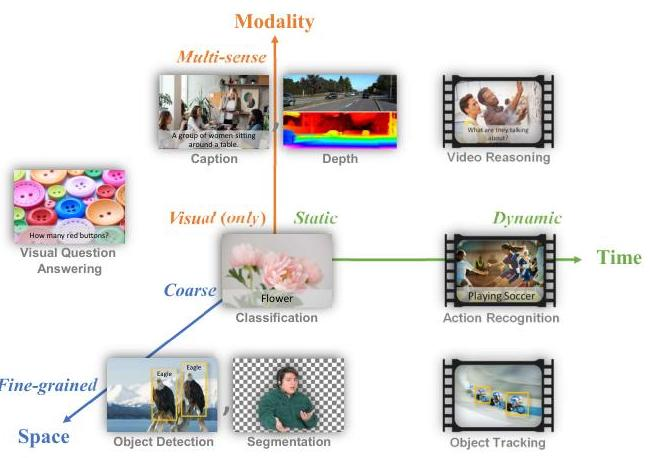

Figure 1. Common computer vision tasks are mapped to a Space-Time-Modality space. A computer vision foundation model should serve as general purpose vision system for all of these tasks.

## 1. Introduction

Human-like AI is not achieved by designing specific models to solve specific problems, but by holistic, joint models that can simultaneously solve diverse, real-world problems without too much human involvement. It is thus desirable to have new AI architectures that learn joint, fundamental representations to support a broad range of downstream AI tasks with limited additional domain knowledge, similar to what humans would do. One such proposal is XYZcode (Huang), where monolingual text (X), audio and visual sensory signals (Y), and multilingual (Z) are organically integrated to create AI models that can speak, hear, see, and understand. Another approach is Pathways (Dean), a single model that can generalize across millions of tasks.

A concrete step towards this direction is the development of foundation models. The term of foundation model was first introduced in (Bommasani et al., 2021) to refer to any model that is trained from broad data at scale that is capable of being adapted (e.g. fine-tuned) to a wide range of downstream tasks. Foundation models become promising due to their impressive performance and generalization capabilities.


[^0]:    *Florence Team member in alphabetic order ${ }^{1}$ Microsoft Cloud and AI ${ }^{2}$ Microsoft Research Redmond. Correspondence to: Lu Yuan $<$ luyuan@microsoft.com>.

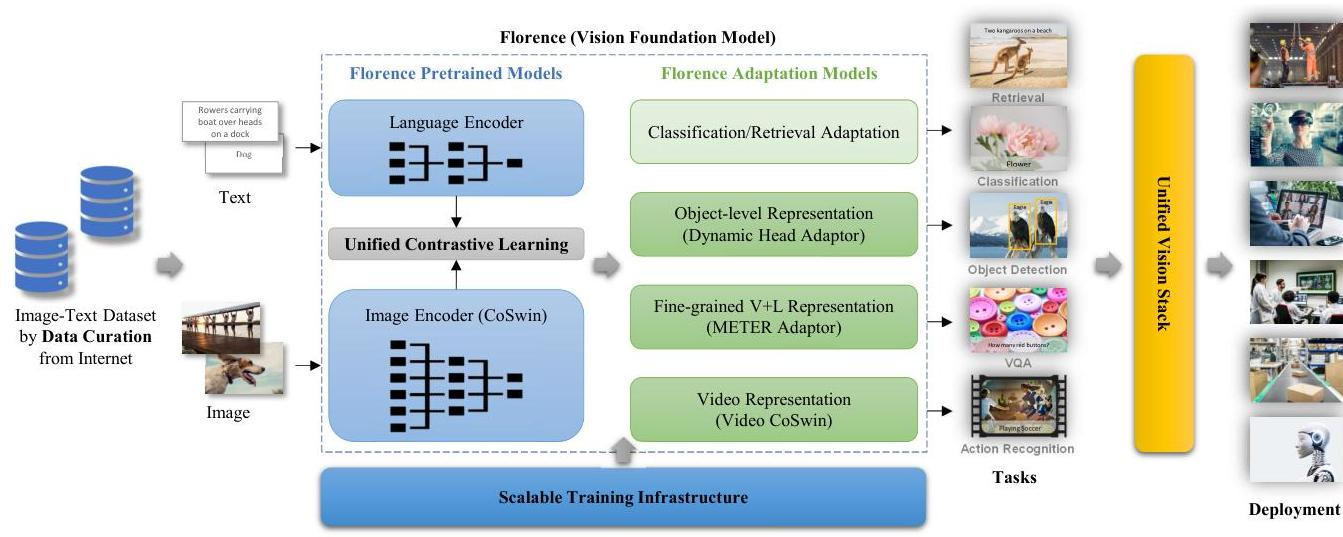

Figure 2. Overview of building Florence. Our workflow consists of data curation, unified learning, Transformer architectures and adaption. It shows the foundation model can be adapted to various downstream tasks and finally integrated into modern computer vision system to power real-world vision and multimedia applications. Compared with existing image-text pretraining models (Radford et al., 2021; Jia et al., 2021; Wud), mainly limited on cross-modal shared representation for classification and retrieval (illustrated by light-green adaptation module), Florence expands the representation to support object level, multiple modality, and videos respectively.

They are quickly integrated and deployed into real-world AI systems by many researchers and developers.

Although foundation models have already demonstrated huge impact in NLP, e.g., BERT (Devlin et al., 2019), GPT-3 (Brown et al., 2020), in computer vision it is still standard practice to pre-train models on labeled data sets such as ImageNet (Deng et al., 2009). More recently, large-scale pre-training methods such as CLIP (Radford et al., 2021), ALIGN (Jia et al., 2021), and Wu Dao 2.0 (Wud), which learn directly from Web-scale image-text pairs, show very encouraging progress for efficient transfer learning, and zero-shot capability. However, such models are restricted to image to text mapping only tasks such as classification, retrieval, and tagging.

We raise the question: "What is the foundation model for computer vision?". But first, in order to better define what "foundation" means in computer vision, we capture the spectrum of tasks in a problem space (Figure 1) with three orthogonal axes: 1) Space: from coarse (e.g. scene-level classification) to fine-grained (e.g. object detection), 2) Time: from static (e.g. images) to dynamic (e.g. videos), and 3) Modality: from RGB only to multiple senses (e.g. captioning and depth). Due to the diversity nature of visual understanding, we redefine foundation models for computer vision to be a pre-trained model and its adapters for solving all vision tasks in this Space-Time-Modality space, with transferability such as zero-/few-shot learning and fully fine tuning, etc. The adaptation for transferability is restricted to minimum customization for the pre-trained foundation models, such as continuing training, few epochs or few layers for fine tuning without significantly increasing or changing model parameters.

In this paper, we present an emerging paradigm for building a vision foundation model, called Florence. We use the name of Florence as the origin of the trail for exploring vision foundation models, as well as the birthplace of Renaissance. Florence is trained on noisy Web-scale data end-to-end with a unifying objective, allowing the model to achieve best-in-class performance across a wide range of benchmarks.

The ecosystem of constructing Florence consists of data curation, model pretraining, task adaptations and training infrastructure, as shown in Figure 2.

- Data curation. Diverse, large-scale data is the lifeblood of foundation models. Enabled by large amounts of publicly available images on the Internet with natural language weak supervision, we curate a new dataset of 900 million image-text pairs for training. As Web-crawled data is usually noisy free-form texts (e.g., word, phrase or sentence), to attain more effective learning, we consider UniCL, a unified image-text contrastive learning objective recently proposed in (Yang et al., 2022), which has demonstrated improvements over contrastive and supervised learning approaches.
- Model pretraining (representation learning). To learn a good representation from image-text pairs, we used a

two-tower architecture including an image encoder and a language encoder, as commonly used in CLIP (Radford et al., 2021) and ALIGN (Jia et al., 2021). For the image encoder, we chose hierarchical Vision Transformers (e.g. , Swin (Liu et al., 2021a), CvT (Wu et al., 2021), Vision Longformer (Zhang et al., 2021a), Focal Transformer (Yang et al., 2021), and CSwin (Dong et al., 2021)). While inheriting performance benefits of the transformer self-attention operations (Dosovitskiy et al., 2021b), these hierarchical architectures model the scale invariance nature of images and have linear computational complexity with respect to image size, a property that is essential to dense prediction tasks such as object detection and segmentation.

- Task adaptations. As we have defined computer vision foundation models to adapt to various downstream tasks, it is vital for Florence to be extensible and transferable for this purpose. We extended the learned feature representation along space (from scene to objects) using the dynamic head adapter (Dai et al., 2021a), time (from static image to videos) via proposed video CoSwin adapter, and modality (from images to language) via METER adapter (Dou et al., 2021). Florence is designed to effectively adapted in the open world via few-shot and zero-shot transfer learning, with the ability of efficient deployment by extra training with few epochs (e.g. in retrieval). Our model can be customized for various domains that applicationdevelopers can use.
- Training infrastructure. For both energy and cost concerns, it is critical to build foundation models with as low cost as possible. We developed scalable training infrastructure to improve training efficiency. It consists of several key techniques such as ZeRO (Rajbhandari et al., 2019), activation checkpointing, mixed-precision training, gradient cache (Gao et al., 2021) to greatly reduce the memory consumption and thus improves the training throughput.

Florence significantly outperforms previous large-scale pretraining methods and achieves new state-of-the-art results on a wide range of vision and vision-language benchmarks. It showed strength in zero-shot transfer in 12 classification downstream tasks (win 9/12, SOTA in ImageNet-1K zeroshot with top-1 accuracy of 83.74 and the top-5 accuracy of 97.18), linear probe in 11 classification downstream tasks (win 9/11), image retrieval zero-shot (90.9/76.7 R@1 on Flickr30K image-to-text / text-to-image, 64.7/47.2 R@1 on MSCOCO image-to-text / text-to-image) and fine-tuning (97.2/87.9 R@1 on Flickr30K image-to-text / text-to-image, 81.8/63.2 R@1 on MSCOCO image-to-text/ text-to-image), object detection ( 62.4 mAP on COCO, 39.3 mAP on Object365, 16.2 AP50 on Visual Genome), VQA (80.36),
text-to-video retrieval zero-shot (37.6 R@1 on MSR-VTT), and video action recognition (top-1 accuracy 86.5/87.8 on Kinetics-400 / Kinetics-600).

## 2. Approach

### 2.1. Dataset Curation

We leverage large quantities of image-text data available publicly on the internet. Specifically, we construct a 900 million image-text-pair dataset, called FLD-900M (FLD stands for FLorenceDataset), using a programmatic data curation pipeline that processes around 3 billion Internet images and their raw descriptions in parallel. Selection and post-filtering is employed to ensure data relevance and quality while respecting legal and ethical constraints. To improve data quality, we performed rigorous data filtering, similar to ALIGN (Jia et al., 2021), including a simple hash-based near-duplicate image removal, small-size image removal, image-text relevance, etc. In addition, we follow the sampling strategy introduced in (Radford et al., 2021; Ramesh et al., 2021) with the goal of achieving improved balance, informativeness, and learnability of the sampled dataset. The final form of the FLD-900M dataset consists of 900 M images with 900 M free-form texts (ranging from one word, phase to sentences), 9.7 M unique queries, and $7.5 B$ tokens in total.

### 2.2. Unified Image-Text Contrastive Learning

CLIP (Radford et al., 2021) implicitly assumes that each image-text pair has its unique caption, which allows other captions to be considered negative examples. However, in web-scale data, multiple images can be associated with identical captions. For example, in FLD-900M, there are 350 M image-text pairs where there are more than one images corresponding to one identical text, and all images associated with the same text can be treated as positive pairs in contrastive learning.

To address this issue, we utilize a unified image-text contrastive learning (UniCL) (Yang et al., 2022), where Florence is pre-trained in an image-label-description space. Given an image-text pair, we generate a triplet $(\boldsymbol{x}, \boldsymbol{t}, \boldsymbol{y})$ via a text hash-table, where $\boldsymbol{x}$ is the image, $\boldsymbol{t}$ is the language description (i.e., hash value), and $\boldsymbol{y}$ is the language label (i.e., hash key) indicating the index of unique language description in the dataset. Note that we only map identical language description to the same hash key, i.e., language label. Thus, all image-text pairs mapped to the same label $\boldsymbol{y}$ are regarded as positive in our universal image-text contrastive learning. Others are still regarded as negative. The unified learning objective in the common image-labeldescription space unifies two popular learning paradigms - mapping images to the label for learning discriminative

representations (i.e. , supervised learning) and assigning each description with a unique label for language-image pre-training (i.e. , contrastive learning).

Our empirical experiments indicate that long language descriptions with rich content would be more beneficial for image-text representation learning than short descriptions (e.g. , one or two words). We have to enrich the short description by generating prompt templates such as "A photo of the [WORD]", "A cropped photo of [WORD]", as data augmentation. During training, we randomly select one template to generate $\boldsymbol{t}$ for each short language description.

Following UniCL *(Yang et al., 2022)*, we denote $f_{\theta}$ and $f_{\phi}$ as the image encoder and text encoder, respectively. $\boldsymbol{u}$ and $\boldsymbol{v}$ are the normalized visual feature vector and language feature vector, respectively, where $\boldsymbol{u}=\frac{f_{\phi}(\boldsymbol{x})}{\left\|f_{\phi}(\boldsymbol{x})\right\|}$, and $\boldsymbol{v}=$ $\frac{f_{\phi}(\boldsymbol{t})}{\left\|f_{\phi}(\boldsymbol{t})\right\|}$. $\tau$ is a learnable temperature. Given a mini-batch $\mathcal{B}$, we use a bi-directional supervised contrastive learning objective between images and language descriptions to train the model as:

$$
\mathcal{L}=\mathcal{L}_{i 2 t}+\mathcal{L}_{t 2 i}
$$

This objective contains two contrastive terms: the supervised image-to-language contrastive loss

$$
\mathcal{L}_{i 2 t}=-\sum_{i \in \mathcal{B}} \frac{1}{|\mathcal{P}(i)|} \sum_{k \in \mathcal{P}(i)} \log \frac{\exp \left(\tau \boldsymbol{u}_{i} \boldsymbol{v}_{k}\right)}{\sum_{j \in \mathcal{B}} \exp \left(\tau \boldsymbol{u}_{i} \boldsymbol{v}_{j}\right)}
$$

where $k \in \mathcal{P}(i)=\left\{k \mid k \in \mathcal{B}, y_{k}=y_{i}\right\}$, and the supervised language-to-image contrastive loss

$$
\mathcal{L}_{t 2 i}=-\sum_{j \in \mathcal{B}} \frac{1}{|\mathcal{Q}(j)|} \sum_{k \in \mathcal{Q}(j)} \log \frac{\exp \left(\tau \boldsymbol{u}_{k} \boldsymbol{v}_{j}\right)}{\sum_{i \in \mathcal{B}} \exp \left(\tau \boldsymbol{u}_{i} \boldsymbol{v}_{j}\right)}
$$

where $k \in \mathcal{Q}(j)=\left\{k \mid k \in \mathcal{B}, y_{k}=y_{j}\right\}$.
The generated language prompt is not a precise description of an image, typically not as informative as the associated text descriptions from the Internet. Although including generated language prompt might not affect classification accuracy, it hurts the performance in retrieval and visionlanguage tasks. To mitigate the negative effect from augmented prompts, our training is separated into two stages. In the first stage, we use all data including augmented texts for training; while in the second stage, we exclude all augmented data for continuing training. We trained $1 M$ iterations in the first stage, and continuously trained $180 K$ iterations in the second stage. The Adam optimizer with decoupled weight decay regularization is utilized for model training. The image size is $224 \times 224$ and the maximum language description length is truncated at 76 . The batch size is 24,576 . We further trained $80 K$ iterations at a higher resolution of $384 \times 384$ to boost the performance, which follows existing pre-training approaches.

### 2.3. Transformer-based Florence Pretrained Models

Our Florence pretrained model uses a two-tower architecture: a 12-layer transformer *(Vaswani et al., 2017)* as language encoder, similar to CLIP *(Radford et al., 2021)*, and a hierarchical Vision Transformer as the image encoder. The hierarchical Vision Transformer is a modified Swin Transformer *(Liu et al., 2021a)* with convolutional embedding, called CoSwin Transformer. Specifically, we replace the patch embedding and patch merging modules in the Swin Transformer *(Liu et al., 2021a)* with the convolutional embedding layers as described in CvT *(Wu et al., 2021)*. We use the CoSwin Transformer with global average pooling to extract image features. Two linear projection layers are added on top of the image encoder and language encoder to match the dimensions of image and language features. Our Florence pretrained model has in total $893 M$ parameters, including the language transformer with $256 M$ parameters and the CoSwin-H transformer with $637 M$ parameters. The model takes 10 days to train on 512 NVIDIA-A100 GPUs with 40GB memory per GPU.

### 2.4. Object-level Visual Representation Learning

We extend the Florence pretrained model to learn finegrained (i.e. , object-level) representation, which is fundamental to dense prediction tasks such as object detection. For this goal, we add an adaptor Dynamic Head *(Dai et al., 2021a)* (or Dynamic DETR *(Dai et al., 2021b)*), a unified attention mechanism for the detection head, to the pretrained image encoder (i.e. , CoSwin). We can continue visual representation learning from coarse (scene) to fine (object).

Based on the hierarchical structure of the image encoder CoSwin-H, we can get the output feature pyramids from the different scale levels. The feature pyramid scale levels can be concatenated and scaled-down or scaled-up into a 3-dimensional tensor with dimensions level $\times$ space $\times$ channel. The key idea of Dynamic Head *(Dai et al., 2021a)* is to deploy three attention mechanisms, each on one of the orthogonal dimensions of the tensor, i.e., level-wise, spatialwise, and channel-wise. Compared with building a single self-attention mechanism over this tensor, Dynamic Head makes the computation more affordable and enables more efficient learning. The above three attention mechanisms are applied sequentially, and we can effectively stack multiple blocks consisting of such three attention layers together. Figure 3 shows the Dynamic Head building blocks. In this work, Dynamic Head is trained with the one-stage ATSS framework and losses.

We have constructed a large-scale object detection dataset, called FLOD-9M (for FLorence Object detection Dataset), for object detection pre-training. We merge several wellknown object detection datasets, including COCO *(Lin et al., 2015)*, LVIS *(Gupta et al., 2019)*, OpenImages *(Krasin

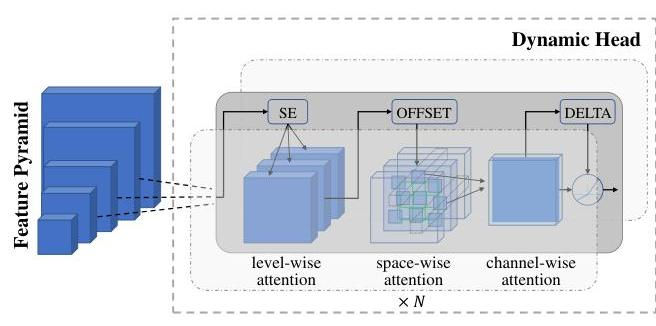

Figure 3. Dynamic Head (Dai et al., 2021a) adapter is used for object-level visual representation learning.
et al., 2016), Object365 (Shao et al., 2019). In addition, we generate pseudo bounding boxes on ImageNet-22K dataset (Deng et al., 2009) by following (Zoph et al., 2020), which further enlarges our data. In the end, FLOD-9M consists of $8,967,286$ images, 25,190 object categories, and $33,408,237$ bounding boxes including annotations and pseudo labels. We then pre-train our Dynamic Head model for 12 epochs with batch size 128, which takes 7 days on 128 NVIDIA-A100 GPUs.

### 2.5. Fine-Grained V+L Representation Learning

We use METER (Dou et al., 2021) adapter to expand to fine-grained vision-language representation. In the visionlanguage area, e.g. visual question answering (VQA) and image captioning, fine-grained representation (i.e. , objectlevel) is indispensable. Thus, the object detector has been a de facto tool for image feature extraction, followed by a fusion network for prediction in many works (Anderson et al., 2018; Li et al., 2020; Zhang et al., 2021b; Wang et al., 2020; Fang et al., 2021; Chen et al., 2020d). Recently, there is an increasing trend (Huang et al., 2021; Xue et al., 2021; Wang et al., 2021; Kim et al., 2021; Dou et al., 2021) of end-to-end approaches to reduce dependency on the object bounding box, which instead consider grid-based feature representations as the fine-grained features for V+L tasks.

In the Florence V+L adaptation model, we replace the image encoder of METER (Dou et al., 2021) with Florence pretrained model CoSwin, and use a pretrained Roberta (Liu et al., 2019) as the language encoder, shown in Figure 4. The Florence pretrained language encoder can be used for this adapter as it utilizes BERT-based architecture. Then, the two modalities are fused together to learn the contextual representation with a transformer network based on coattention. The co-attention model (Figure 4) allows feeding the text and visual features to two $M_{c o}$-layer transformers separately, and each top transformer encoding layer consists of one self-attention block, one cross-attention block, and one feed-forward network block. We first train the model
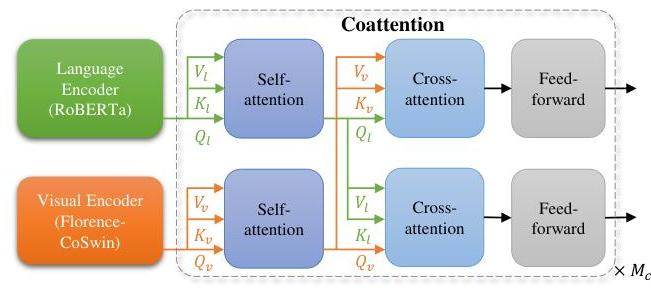

Figure 4. METER (Dou et al., 2021) is used as Florence V+L adaptation model, trained with the image-text matching (ITM) loss and the masked language modeling (MLM) loss.
with the image-text matching loss and the masked-language modeling loss. Then, we fine-tune the model on the downstream task, such as VQA (Goyal et al., 2017) task.

### 2.6. Adaption to Video Recognition

The self-attention based design in Transformer makes it possible to unify the systems of image and video recognition. Our Video CoSwin adapter can borrow the image encoder from CoSwin for the video domain with minimum changes, similar to prior work (Liu et al., 2021b). First, the image tokenization layer is replaced with a video tokenization layer. Accordingly, video CoSwin replaces the tokenization layer of CoSwin (in Section 2.3) from 2D convolutional layers to 3D convolutional layers, which converts each 3D tube into one token. As the initialization to 3D convolutional weights, the pre-trained 2D convolutional weights of CoSwin are duplicated along the temporal dimension and divided by the temporal kernel size to keep the mean and variance of the output unchanged. Second, video CoSwin uses the 3D convolution-based patch merging operator instead of the 2D patch merging operator used in (Liu et al., 2021b). Such overlapped token merging can enhance spatial and temporal interactions among tokens. Third, we follow prior work (Liu et al., 2021b) to replace the 2D shifted window design with 3D shifted local windows in self-attention layers. We duplicate the 2D relative positional embedding matrix from the pre-trained CoSwin along the temporal dimension to initialize the 3D positional embedding matrix. In this way, the 2D relative positional embedding is the same for each temporal shift. In addition, all other layers and weights (including self-attention, FFN) can be inherited directly from the pre-trained CoSwin. To mitigate memory issues in the video training, we adopt the dynamic window size strategy, i.e., a relatively small window size in early stages of CoSwin, and large window sizes in its later stages.

|  | Food101 | CIFAR10 | CIFAR100 | SUN397 | Stanford Cars | FGVC Aircraft | VOC3007 | GTD | Oxford Pens | Caltech101 | Flowers102 | ImageNet |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| CLIP-ResNet-50x64 | 91.8 | 86.8 | 61.3 | 48.9 | 76.0 | 35.6 | 83.8 | 53.4 | 93.4 | 90.6 | 77.3 | 73.6 |
| CLIP-ViT-L/14 (@336pix) | 93.8 | $\underline{95.7}$ | 77.5 | 68.4 | 78.8 | 37.2 | 84.3 | 55.7 | 93.5 | 92.8 | 78.3 | 76.2 |
| FLIP-ViT-L/14 | 92.2 | $\underline{95.7}$ | 75.3 | 73.1 | 70.8 | $\underline{60.2}$ | - | 60.7 | 92.0 | 93.0 | $\underline{90.1}$ | 78.3 |
| Florence-CoSwin-H (@384pix) | $\underline{95.1}$ | 94.6 | $\underline{77.6}$ | $\underline{77.0}$ | $\underline{93.2}$ | 55.5 | $\underline{85.5}$ | $\underline{66.4}$ | $\underline{95.9}$ | $\underline{94.7}$ | 86.2 | $\underline{83.7}$ |

Table 1. Zero-shot transfer of image classification comparisons on 12 datasets: CLIP-ResNet-50x64 *(Radford et al., 2021)*, FLIP-ViTL/14 *(Yao et al., 2021)*.
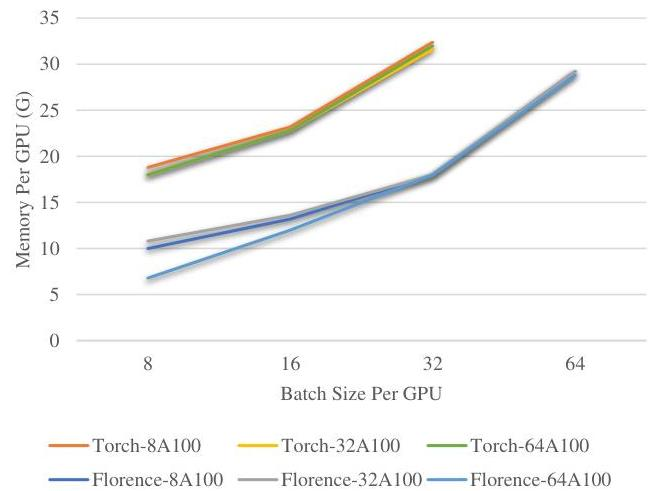

Figure 5. GPU memory reduction for various batch sizes. We compared the profiling between Torch (w/o optimization) and Florence (w/ optimization) on various number of GPUs.

### 2.7. Scalable Training Infrastructure

To train the Florence model on our large-scale dataset, our scalable training infrastructure faces two main challenges: reducing memory cost on each GPU and increasing the throughput. Reducing the memory cost allows us to feed more data into each GPU and use a larger batch size, which has been proved to be effective for contrastive learning. Increasing the throughput can significantly speed up the whole training process and thus reduce carbon emissions. We have developed several techniques that can be combined to achieve the two goals:

Zero Redundancy Optimizer (ZeRO) The ZeRO technique *(Rajbhandari et al., 2019)* partitions the optimizer states, gradients and parameters across the GPUs and each partition is only updated locally. Thus, the memory consumption is largely reduced.

Activation Checkpointing For a checkpointed model component, e.g. , multi-head attention, it reruns a forward pass during backward pass. In this way, the internal gradients in the component do not need to be stored in the forward pass and then reduce the memory cost in the training.

Mixed-precision Training In mixed-precision training, various operations are trained with different numerical precision (i.e. , float-32 or float-16). Float-32 is used for numerically less stable operations, such as layer normalization; while float-16 is used for the other operations. Such a combination improves the training throughput and maintains the model performance.

Gradient Cache The gradient cache technique *(Gao et al., 2021)* is able to increase the total batch size in a training step. A large batch size is shown to be beneficial to learn better representations in previous works. However, it is bounded by available GPU memory. To resolve this problem, we factor the contrastive loss by breaking the large batch gradient update into several sub-updates that can fit into GPU memory. It enables us to train big models with a large batch size.

Thanks to these above optimizations, we can achieve consistent improvement in reducing GPU memory for variable batch sizes on various numbers of NVIDIA-A100s, shown in Figure 5.

## 3. Experiments

### 3.1. Zero-shot Transfer in Classification

In computer vision, zero-shot learning usually refers to the study of predicting classes that are defined via descriptive text. As a vision foundation model, Florence can be directly used to predict if an image and a text snippet are semantically matched together in the task dataset. We follow the same method of CLIP *(Radford et al., 2021)* to perform

|  | Food101 | CIFAR10 | CIFAR100 | SUN397 | Stanford Cars | FGVC Aircraft | VOC2007 | DTD | Oxford Pets | Caltech101 | Flowers102 |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| SimCLRv2-ResNet-152x3 | 83.6 | 96.8 | 84.5 | 69.1 | 68.5 | 63.1 | 86.7 | 80.5 | 92.6 | 94.9 | 96.3 |
| ViT-L/16 (@384pix) | 87.4 | 97.9 | 89.0 | 74.9 | 62.5 | 52.2 | 86.1 | 75.0 | 92.9 | 94.7 | 99.3 |
| EfficientNet-L2 (@800pix) | 92.0 | $\underline{\mathbf{9 8 . 7}}$ | $\underline{\mathbf{8 9 . 0}}$ | 75.7 | 75.5 | 68.4 | 89.4 | 82.5 | 95.6 | 94.7 | 97.9 |
| CLIP-ResNet-50x64 | 94.8 | 94.1 | 78.6 | 81.1 | 90.5 | 67.7 | 88.9 | 82.0 | 94.5 | 95.4 | 98.9 |
| CLIP-ViT-L/14 (@336pix) | 95.9 | 97.9 | 87.4 | 82.2 | 91.5 | 71.6 | 89.9 | 83.0 | 95.1 | 96.0 | 99.2 |
| Florence-CoSwin-H (@384pix) | $\underline{\mathbf{9 6 . 2}}$ | 97.6 | 87.1 | $\underline{\mathbf{8 4 . 2}}$ | $\underline{\mathbf{9 5 . 7}}$ | $\underline{\mathbf{8 3 . 9}}$ | $\underline{\mathbf{9 0 . 5}}$ | $\underline{\mathbf{8 6 . 0}}$ | $\underline{\mathbf{9 6 . 4}}$ | $\underline{\mathbf{9 6 . 6}}$ | $\underline{\mathbf{9 9 . 7}}$ |

Table 2. Comparisons of image classification linear probing on 11 datasets with existing state-of-the-art models, including SimCLRv2 (Chen et al., 2020c), ViT (Dosovitskiy et al., 2021a), EfficientNet (Xie et al., 2020), and CLIP (Radford et al., 2021).
zero-shot classification. For each dataset, we use the names of all the classes in the dataset as the set of potential text pairings and predict the most probable (image, text) pair according to Florence. We compute the feature embedding of the image for CoSwin and the feature embedding of the set of possible texts by the language encoder. The cosine similarities among these embeddings are then calculated, and then we rank the similarity scores over all the classes to select the Top-1 or Top-5 classes as the predicted classes. Here, we do not need to compute the normalized cosine similarity as done in (Radford et al., 2021), since it won’t affect the ranking order of final results.

We evaluate our Florence model on the ImageNet-1K dataset and 11 downstream datasets from the well-studied evaluation suit introduced by (Kornblith et al., 2019). Note that our benchmarks exclude the Birdsnap (Berg et al., 2014) dataset from 12 original classification datasets introduced in (Kornblith et al., 2019), because $20 \%$ of the image URLs provided by the authors are invalid. We follow the same prompt templates and engineering, and ensembling as previously proposed in (Radford et al., 2021) for evaluating zero-shot performance. For all zero-shot tasks in this paper, we follow the setup in CLIP (Radford et al., 2021) and ALIGN (Jia et al., 2021) to remove near-duplicate test images from our training data. Table 1 shows the results over these 12 datasets, in comparison with the best performance achieved by both CLIP ResNet and Vision Transformer models, and the concurrent work FILIP (Yao et al., 2021). Florence outperforms on $9 / 12$ tasks compared with state-of-the-art methods. We achieved a remarkable improvement in the zero-shot transfer on ImageNet-1K - the top-1 accuracy of $83.74 \%(+5.6 \%$ over SOTA result), and the top-5 accuracy of $97.18 \%$.

### 3.2 Linear Probe in Classification

Linear probe as another main metric for evaluating representation quality has been used in most recent studies, including self-supervised learning (Chen et al., 2020b;c), self-training with noisy student (Xie et al., 2020) and contrastive learning (Radford et al., 2021). We follow the same setting and implementation of CLIP (Radford et al., 2021) for linear evaluation, where the image encoder (or vision backbone) is frozen, and only the appended linear layers can be fine-tuned on the downstream datasets. We use public available models (shown in Table 10 (Radford et al., 2021)) to verify the correctness of our own implementation. The variance between our reproduced results and their reported results is $\pm 0.1$ for each task. Our linear evaluation considers 11 classification benchmarks which are also used for our zero-shot transfer of classification. We compared our results with state-of-theart methods with their best performance models, including SimCLRv2 (Chen et al., 2020c), ViT (Dosovitskiy et al., 2021a), Noisy Student (Xie et al., 2020) and CLIP (Radford et al., 2021) on Table 2. Our results are consistently better than existing state-of-the-art results, expect for two datasets: CIFAR10, CIFAR100. On the two datasets, the input image resolution is quite low (i.e. , $32 \times 32$ ). Training with higher resolution definitely boosts the performance,such as Efficient-L2 (Xie et al., 2020) which achieves the best accuracy compared with all other approaches trained on lower-resolution images.

### 3.3 ImageNet-1K Fine-tune Evaluation

Florence can be easily adapted to support continual finetuning on target classification tasks. We do not change or add anything into our architecture, but continue the training on task-specific data using the same pre-training loss (shown in Equation 1). We feed the class name to the text encoder of Florence to get the text feature embedding. We use the

| Model | Params | Data | Accuracy |  |
| --- | --- | --- | --- | --- |
| | | | Top-1 | Top-5 |
| BiT-L-ResNet152x4 | 928M | 300M | 87.54 | 98.46 |
| ALIGN-Efficient-L2 | 480M | 1800M | 88.64 | 98.67 |
| ViT-G/14 | 1843M | 3000M | 90.45 | - |
| CoAtNet-7 | 2440M | 3000M | 90.88 | - |
| Florence-CoSwin-H | 637M | 900M | 90.05 | 99.02 |

Table 3. Classification fine tuning on ImageNet-1K. Florence is compared with: BiT-L-ResNet152x4 *(Kolesnikov et al., 2020)*, ALIGN-Efficient-L2 *(Jia et al., 2021)*, ViT-G/14 *(Zhai et al., 2021)*, CoAtNet-7 *(Dai et al., 2021c)* in terms of model scale, data scale and Top-1/Top-5 accuracy.
same prompt templates as in *(Radford et al., 2021; Jia et al., 2021)* to expand the descriptions of ImageNet *(Deng et al., 2009)* class names.

We evaluate the performance of continual fine-tuning on ImageNet ILSVRC-2012 benchmark *(Deng et al., 2009)*. Our image encoder CoSwin-H is fine-tuned at the resolution of $512 \times 512$ with a batch size of 8,192 for 10 epochs. We use a cosine learning rate decay scheduler with 500 warmup steps and a peak learning rate of 0.00002 . The comparisons with state-of-the-art results are shown in Table 3. Our model outperforms BiT *(Kolesnikov et al., 2020)* with larger model size and ALIGN *(Jia et al., 2021)* trained from more data in terms of Top-1 and Top-5 accuracy. Our result is slightly worse than SOTA *(Dai et al., 2021c)*, but their model and data scale are both $3 \times$ larger.

### 3.4 Few-shot Cross-domain Classification

The Cross-Domain Few-Shot learning benchmark *(Guo et al., 2020)* is used to measure an algorithm's capability to adapt to downstream few-shot target tasks, containing domains with varying levels of dissimilarity to typical consumer photographs. The datasets in the benchmark include: CropDisease *(Mohanty et al., 2016)* (plant leaf images, 38 disease states over 14 plant species), EuroSAT *(Helber et al., 2019)* (RGB satellite images, 10 categories), ISIC 2018 *(Codella et al., 2019; Tschandl et al., 2018)* (dermoscopic images of skin lesions, 7 disease states), and ChestX *(Wang et al., 2017)* (Chest X-rays, 16 conditions). Exemplar image for each dataset is shown on the top of Table 4. The evaluation protocol involves 5-way classification across 5-shot, 20-shot, and 50-shot. The classes and shots are randomly sampled for each episode, for 600 episodes per way and shot. Average accuracy over all episodes is reported.

To predict the class, we append a single linear layer as an adapter head to our image encoder CoSwin. Training occurs

| ISIC |  | EuroSAT |  | CropDisease |  | ChestX |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|  | Model | ISIC | EuroSAT | CropD | ChestX | mean |
| 5-shot | CW | 57.4 | 88.1 | 96.6 | 29.7 | 68.0 |
|  | Florence | 57.1 | 90.0 | 97.7 | 29.3 | 68.5 |
| 20-shot | CW | 68.1 | 94.7 | 99.2 | 38.3 | 75.1 |
|  | Florence | 72.9 | 95.8 | 99.3 | 37.5 | 76.4 |
| 50-shot | CW | 74.1 | 96.9 | 99.7 | 44.4 | 78.8 |
|  | Florence | 78.3 | 97.1 | 99.6 | 42.8 | 79.5 |

Table 4. Comparison with CW *(Liu et al., 2020)* (CD-FSL Challenge 2020 Winner) on CD-FSL benchmark. The average result comparison is 74.8 (Florence) vs. 73.9 (CW).
over 100 epochs per episode. We use SGD with momentum, with learning rate and momentum values of $0.9 / 0.0002$, respectively, for CoSwin, and $0.99 / 0.01$, respectively, for the adapter head. Horizontal data flip augmentation is used for training and test, and dropout of 0.5 is used between the image encoder and the classifier head.

Table 4 shows the results of adapting our model to the CDFSL benchmark, in comparison to the winner of the challenge benchmark *(Liu et al., 2020)*, which employs ensembes and transductive learning. By comparison, we employ a single model and no transduction on the test data is performed, yet we achieve higher results without any "bells and whistles".

### 3.5 Image-Text Retrieval

Table 5 presents the zero-shot transfer and fine-tuning performance of Florence for both text and image retrieval on the Flickr30k *(Plummer et al., 2016)* and MSCOCO *(Lin et al., 2015)* datasets.

For zero-shot retrieval, we feed the input text (or image) to the language (or image) encoder of Florence to get the feature embeddings, and also compute the feature embeddings of the set of possible images (or texts) by the image (or language) encoder. Then we compute cosine similarity of these embeddings and rank the similarity scores over the testing set to select the Top-1 or Top-5 results. Zero-shot Florence matches or outperforms all prior zero-shot results on these two datasets.

For fine-tuning retrieval, we continuously train our language and text encoders on the target image-text pair data, as well

|  |  | Flickr30K (1K test set) |  |  |  | MSCOCO (5K test set) |  |  |  |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|  | Method | Image $\rightarrow$ Text |  | Text $\rightarrow$ Image |  | Image $\rightarrow$ Text |  | Text $\rightarrow$ Image |  |
|  |  | R@1 | R@5 | R@1 | R@5 | R@1 | R@5 | R@1 | R@5 |
| Zero-shot | ImageBERT *Qi et al. (2020)* | 70.7 | 90.2 | 54.3 | 79.6 | 44.0 | 71.2 | 32.3 | 59.0 |
|  | UNITER *Chen et al. (2020d)* | 83.6 | 95.7 | 68.7 | 89.2 | - | - | - | - |
|  | CLIP *Radford et al. (2021)* | 88.0 | 98.7 | 68.7 | 90.6 | 58.4 | 81.5 | 37.8 | 62.4 |
|  | ALIGN *Jia et al. (2021)* | 88.6 | 98.7 | 75.7 | 93.8 | 58.6 | 83.0 | 45.6 | 69.8 |
|  | FLIP *Yao et al. (2021)* | 89.8 | 99.2 | 75.0 | 93.4 | 61.3 | 84.3 | 45.9 | 70.6 |
|  | Florence | 90.9 | 99.1 | 76.7 | 93.6 | 64.7 | 85.9 | 47.2 | 71.4 |
| Fine-tuned | GPO *Chen et al. (2020a)* | 88.7 | 98.9 | 76.1 | 94.5 | 68.1 | 90.2 | 52.7 | 80.2 |
|  | UNITER *Chen et al. (2020d)* | 87.3 | 98.0 | 75.6 | 94.1 | 65.7 | 88.6 | 52.9 | 79.9 |
|  | ERNIE-ViL *Yu et al. (2020)* | 88.1 | 98.0 | 76.7 | 93.6 | - | - | - | - |
|  | VILLA *Gan et al. (2020)* | 87.9 | 97.5 | 76.3 | 94.2 | - | - | - | - |
|  | Oscar *Li et al. (2020)* | - | - | - | - | 73.5 | 92.2 | 57.5 | 82.8 |
|  | ALIGN *Jia et al. (2021)* | 95.3 | 99.8 | 84.9 | 97.4 | 77.0 | 93.5 | 59.9 | 83.3 |
|  | FLIP *Yao et al. (2021)* | 96.6 | 100.0 | 87.1 | 97.7 | 78.9 | 94.4 | 61.2 | 84.3 |
|  | Florence | 97.2 | 99.9 | 87.9 | 98.1 | 81.8 | 95.2 | 63.2 | 85.7 |

Table 5: Image-text retrieval comparisons on Flickr30K and MSCOCO datasets (zero-shot and fine-tuned).
as classification fine-tuning (shown in Section 3.3). We finetune our model with a batch size of 3,072 for 12 epochs. We use the cosine learning rate decay scheduler with 200 warmup steps and a peak learning rate of 0.00002 . Our results are superior to all previous fine-tuning results on the two datasets. Moreover, our fine tuning on retrieval is more efficient, with only roughly $6 \%$ and $8 \%$ fine-tuning epochs of ALIGN *Jia et al. (2021)* on Flickr30k and MSCOCO respectively.

### 3.6 Object Detection and Zero-shot Transfer

Object detection is one of the most prominent applications in computer vision. Compared with existing large-scale pre-trained models (e.g., CLIP *Radford et al. (2021)*, ALIGN *Jia et al. (2021)*, Wu Dao 2.0 [26]), Florence is more desirable for object detection since its adaptation helps learn visual representation at the object level. We evaluate its performance of object-level visual representations via fine-tuned object detection and zero-shot transfer tasks.

Fine-tuning We evaluate fine-tuning on three popular object detection datasets: COCO *Lin et al. (2015)*, Object365 *Shao et al. (2019)*, and Visual Genome *Krishna et al. (2016)*. For COCO, we increase the maximum image side to 2,500 and fine-tune with multi-scale training for 12 epochs. We follow the same multi-scale testing strategy widely used in existing state-of-the-art approaches. For Object365, we use the same input resolution of images (i.e., the maximum image side 1,333 ) as the Multi-dataset Detec-
tion $^{1}$ *Zhou et al. (2021)* for fine-tuning. For Visual Genome, we increase the maximum side of input resolution to 3,000 and fine-tune with multi-scale training for 24 epochs. To leverage attributes annotations in Visual Genome, we insert an $1 \times 1$ ROI pool on the final stage of CoSwin backbone to extract features for attribute learning, which allows the object detection adapter being optimized for multi-task learning.

We compare Florence with state-of-the-art results on these three benchmarks in Table 6. In object detection, the standard mean average precision (AP) metric is used to report results under different IoU thresholds and object scales for all datasets. We follow the metrics used in existing state-of-the-art methods. For COCO, Object365 and zero-shot transfer benchmarks, we use mAP, i.e., average over multiple IoUs ( $0.5: 0.05: 0.95$ ). For Visual Genome, we use AP50 at IoU threshold 0.5 . As we can see, Florence establishes new results in these main benchmarks of object detection.

Zero-shot Transfer Zero-shot object detection is more challenging than zero-shot classification, since neither object proposal classification nor location (i.e., bounding box regression) in downstream tasks is seen during training. In our zero-shot transfer setting, object proposal and object classification are decoupled into two tasks. Object proposal discriminates object from background, ignoring semantics

[^0]
[^0]:    ${ }^{1}$ This work was ranked 1 -st in the object detection track of ECCV 2020 Robust Vision Challenge.

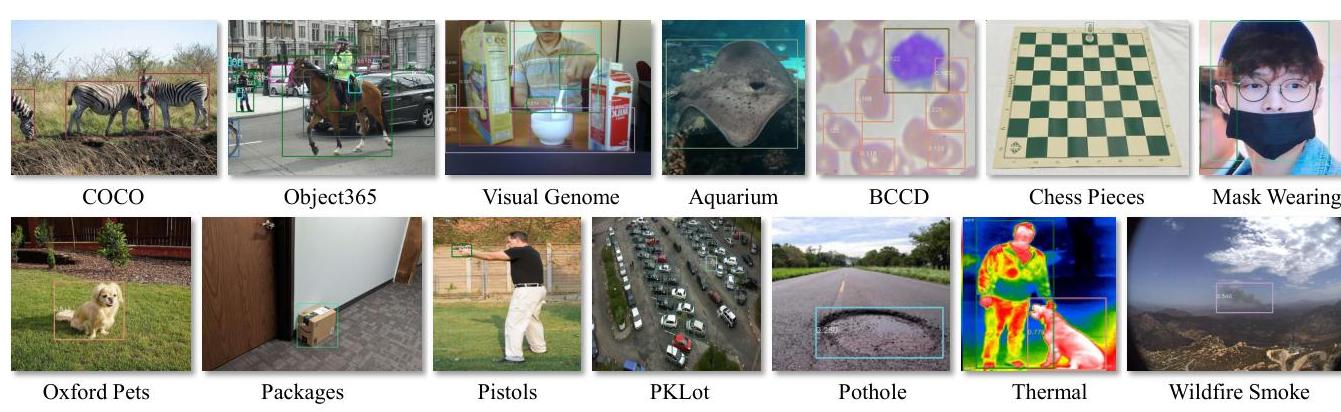

Figure 6. Our fine-tuned detection results on COCO (sparse object boxes), Object365 (dense object boxes), Visual Genome (w/ object attributes), and zero-shot transfer results on 11 downstream detection tasks. Boxes with different colors denote different object categories.

| Benchmark | Model | AP |
| :--: | :-- | :--: |
| COCO miniVal | DyHead | 60.3 |
|  | Soft Teacher | 60.7 |
|  | Florence | $\underline{\mathbf{6 2 . 0}}$ |
| COCO test-Dev | DyHead | 60.6 |
|  | Soft Teacher | 61.3 |
|  | Florence | $\underline{\mathbf{6 2 . 4}}$ |
| Object365 | Multi-dataset Detection | 33.7 |
|  | Florence | $\underline{\mathbf{3 9 . 3}}$ |
| Visual Genome | VinVL | 13.8 |
|  | Florence | $\underline{\mathbf{1 6 . 2}}$ |

Table 6. Object detection fine tuning comparisons with state-of-the-art methods, including DyHead *Dai et al. (2021a)*, Soft Teacher *Xu et al. (2021b)*, Multi-dataset Detection *Zhou et al. (2021)*, VinVL *Zhang et al. (2021b)*.
of object categories. Classification, on the other hand, focuses on object semantics for each bounding box proposal. In spirit, this setup is similar to the behavior of R-CNN model *Girshick et al. (2014)* which has been widely used for object detection before. Using this approach, we can follow existing work on zero-shot image classification to zeroshot transfer in object detection, to evaluate the Florence for novel object recognition. As mentioned in ZSD *Bansal et al. (2018)*, it more approaches real world settings.

For zero-shot transfer, the training of the detection adapter can be different from fine-tuning. Specifically, we freeze the CoSwin backbones and pre-train the Dynamic Head on FLOD-9M by neglecting semantics from each object bounding box. We treat the object detection pre-training as general-purpose object proposal training. Note that the detection pre-training only updates the object adapter, and
does not affect the fused feature representations learned from large-scale image-text pairs. In inference, we apply the pre-trained CoSwin and Dynamic Head on downstream datasets, and obtain the object proposals for every image. For each object proposal, we apply zero-shot classification, as described in Section 3.1.

To evaluate Florence's transferability to novel, diverse and application-oriented tasks, following *Li et al. (2021b)*, we curate an "open-set oject detection benchmark" which aggregates 11 public datasets from Roboflow ${ }^{2}$, spanning scenarios including fine-grained fishes/chess detection, drone-view detection, and thermal object detection. We use their split test datasets for evaluation. Table 7 shows that our Florence model effectively zero-shot transfers to these tasks. We use the results of the baseline approach ZSD *Bansal et al. (2018)*, which considers a similar setting, for reference. In our implementation ${ }^{3}$, we replace their supervised object detector FasterRCNN with the recent SOTA detector *Dai et al. (2021a)* and use pre-trained BERT as the language encoder. Both are pre-trained end-to-end on the Objects365 dataset. Thanks to large-scale image-text pretraining, Florence shows remarkable gains on all tasks. Zero-shot in object detection still has a long way to be applied to real-world tasks. We further compare Florence zero-shot with previous state-of-the-art detector ${ }^{4}$ *Dai et al. (2021a)* (on COCO) fine-tunning on these tasks. We can observe noticeable performance gap between zero-shot and supervised learning, especially for novel scenarios whose concepts/classes may not be covered by the pre-training dataset, such as "BCCD" (blood cells photos), "Chess Pieces" (Chess board photos and various pieces). However, the results are encouraging when compared with few-shot fine-tuning results. Florence outperforms in 7/11 tasks over 5-shot fine tuning, and outperforms full-set fine-tuning on the "Packages"

[^0]
[^0]:    ${ }^{2}$ https://public.roboflow.com/object-detection
    ${ }^{3}$ We refer to *Li et al. (2021b)* for details.
    ${ }^{4}$ It is pre-trained on ImageNet and COCO in supervised way.

|  |  | Aquarium | BCCD | Chess Pieces | Mask Wearing | Oxford Pets | Packages | Pistols | PKLot | Pothole | Thermal | Wildfire Smoke |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|  | Images | 638 | 364 | 292 | 149 | 3680 | 26 | 2986 | 12416 | 665 | 203 | 737 |
|  | Categories | 7 | 3 | 12 | 2 | 37 | 1 | 1 | 2 | 1 | 2 | 1 |
| Fine-tuned | DyHead-Swin-L (full) | 53.1 | 62.6 | 80.7 | 52.0 | 85.9 | 52.0 | 74.4 | 98.0 | 61.8 | 75.9 | 58.7 |
|  | DyHead-Swin-L (5-shot) | 39.0 | 40.6 | 57.3 | 26.8 | 47.5 | 32.8 | 20.0 | 22.1 | 10.8 | 54.9 | 14.2 |
| Zero-shot | ZSD | 16.0 | 1.2 | 0.1 | 0.6 | 0.3 | 58.3 | 31.5 | 0.2 | 2.4 | 37.4 | 0.002 |
|  | Florence | 43.1 | 15.3 | 13.4 | 15.0 | 68.9 | 79.6 | 41.4 | 31.4 | 53.3 | 46.9 | 48.7 |

Table 7. Zero-shot transfer in object detection, in comparison with previous state-of-the-art model DyHead (Dai et al., 2021a) (on COCO) fine tuning results on full-set or 5-shot respectively and zero-shot detection baseline model ZSD (Bansal et al., 2018).
dataset, consisting of only 26 images for training. It demonstrates the foundation models' great potential of improving data efficiency and reducing deployment cost for new tasks or domains.

### 3.7. V+L Representation Learning

The vision-langauge pretraining (VLP) is performed on MSCOCO (Lin et al., 2015), Conceptual Captions (CC) (Sharma et al., 2018), CC12M (Changpinyo et al., 2021), SBU (Ordonez et al., 2011), and Visual Genome (VG) (Krishna et al., 2016). These datasets result in 14 million images with 20 million associated captions. Beyond replacing the image encoder with CoSwin-H of our Florence model on (Dou et al., 2021), we remove the weight decay on the text embedding layer and the modality-specific embedding. ITM and MLM are applied for VLP with 43 epochs with the image input size as 384 .

To evaluate the performance, we fine-tune the pre-trained model on the challenging VQA (Goyal et al., 2017) task, which is to answer a question based on the image context. The dataset consists of 82 K training images and 41 K validation images. Only 1 K validation images are reserved and the rest are merged with the training data for fine-tuning. As a common practice, the problem is cast as a classification task where each class corresponds to an answer. The final pooling representations are fed into a randomly-initialized multilayer perceptron (MLP) network to predict the answer over 3,129 answers. The loss is the binary cross-entropy loss, and the inference is to select the answer with the highest confidence. The model is fine-tuned for 10 epochs with the learning rate as $8 e-6$ and is evaluated on the test-dev and test-std. The final accuracy is calculated on the public server ${ }^{5}$.

[^0]Table 8. Compare our model with the existing state-of-the-art methods on VQA.

Figure 8 shows the comparison results with the existing methods. As we can see, we achieve the new state-of-the-art performance. Compared with SimVLM (Wang et al., 2021), which uses 1.8B image-text pairs, we only use 900M data to pre-train the image encoder and 20M for VLP, but achieve better results. This also demonstrates the data efficiency of our approach.

### 3.8. Zero-Shot Text-to-Video Retrieval

Although Florence is pre-trained on image-text pairs, it can be easily adapted to video tasks (shown in Section 2.6), such as text-video retrieval. We expand the input 2D patch embeddings and positional embeddings to 3D so that the encoder can process video inputs, following (Arnab et al., 2021). Then, we perform zero-shot text-to-video evaluation


[^0]:    ${ }^{5}$ http://evalai.com

| Method | Pre-training Type | Pre-training Data | R@1 | R@5 | R@10 |
| --- | --- | --- | --- | --- | --- |
| MIL-NCE (Miech et al., 2020) | Video | HowTo100M | - | - | 32.4 |
| MMV (Alayrac et al., 2020) | Video | HowTo100M, AudioSet | - | - | 31.1 |
| VideoCLIP (Xu et al., 2021a) | Video ${ }^{*}$ | HowTo100M | 10.4 | 22.2 | 30.0 |
| VATT (Akbari et al., 2021) | Video | HowTo100M, AudioSet | - | - | 29.7 |
| MCN (Chen et al., 2021) | Image and Video | HowTo100M | - | - | 33.8 |
| Frozen-in-Time (Bain et al., 2021) | Image and Video | ImageNet, CC, WebVid-2M | 18.7 | 39.5 | 51.6 |
| CLIP-ViT-B/16 (Radford et al., 2021) | Image | WIT400M | 26.0 | 49.4 | 60.7 |
| Florence | Image | FLD-900M | $\underline{37.6}$ | $\underline{63.8}$ | $\underline{72.6}$ |

Table 9. Zero-shot text-to-video retrieval results on MSR-VTT 1K-A test set. (*: Feature extracted from the pre-trained model (Miech et al., 2020), followed by another stage of video-and-language pre-training) The pretraining data used in these existing methods include HowTo100M (Miech et al., 2019), AudioSet (Gemmeke et al., 2017), ImageNet (Deng et al., 2009), CC (Sharma et al., 2018), WebVid-2M (Bain et al., 2021), WIT400M (Radford et al., 2021)

| Method | Pretraining Data | Kinetics-400 |  | Kinetics-600 |  | Views | Params |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|  |  | Top-1 | Top-5 | Top-1 | Top-5 |  |  |
| ViViT-H/16x2 | JFT-300M | 84.8 | 95.8 | 85.8 | 96.5 | $4 \times 3$ | 648 M |
| VideoSwin-L | ImageNet-22K | 84.6 | 96.5 | 85.9 | 97.1 | $4 \times 3$ | 200 M |
| VideoSwin-L | ImageNet-22K | 84.9 | 96.7 | 86.1 | 97.3 | $10 \times 5$ | 200 M |
| TokenLearner 16at18+L/10 | JFT-300M | 85.4 | 96.3 | 86.3 | 97.0 | $4 \times 3$ | 460 M |
| Florence | FLD-900M | $\underline{86.5}$ | $\underline{97.3}$ | $\underline{87.8}$ | $\underline{97.8}$ | $4 \times 3$ | 647 M |

Table 10. Comparison to state-of-the-art methods, including ViViT (Arnab et al., 2021), VideoSwin (Liu et al., 2021b), TokenLearner (Ryoo et al., 2021), on Kinetics-400 and Kinetics-600. Views indicate \#temporal clip $\times \#$ spatial crop.
on the MSR-VTT (Xu et al., 2016) dataset. We report results on the 1 K -A test (Yu et al., 2018), which contains 1 K video and caption pairs. We use the standard recall metrics for evaluation and compare with existing state-of-the-art methods in Table 9. As we can see, these two image-text pretrained models CLIP $^{6}$ (Radford et al., 2021) and Florence outperform all the state-of-the-art methods by a large margin in terms of the $R @ 1$ metric. It reveals that the video data used for pretraining in these state-of-the-art methods may not be so rich or diverse as image-text data used in Florence or CLIP.

### 3.9. Video Action Recognition

We evaluate Florence on fine-tuned video action recognition tasks. On the Kinectics-400 and Kinectics-600 datasets, we follow the typical fine-tuning setting (Liu et al., 2021b) and fine tune the model (Section 2.6) with $384 \times 384$ resolution for 30 epochs. We use the label smoothing, rand augmentation, a small learning rate 0.0002 and a relatively large drop path rate 0.5 to avoid over-fitting the target video datasets. We compare with existing state-of-the-art methods

[^0]in Table 10. Our results are better than the state-of-theart by $1.1 \%$ and $1.5 \%$ on Kinectics-400 and Kinectics-600, respectively.

## 4. Conclusion and Future Work

In this paper we investigated a new paradigm of building a computer vision foundation model, Florence, as a generalpurpose vision system. Our attempt is a step towards building XYZ-code (Huang), an integrative AI system that makes progress toward human-like AI. Although the model size is still below several other existing billion-scale models, Florence successfully extends to different tasks along space, time, and modality, with great transferbility, and achieves new SOTA results on a wide range of vision benchmarks.

For the future work, we plan to include more vision tasks and applications, such as depth/flow estimation, tracking, and additional vision+language tasks. Florence is designed to pave the way for building vision foundation models to power millions of real-world vision tasks and applications. In addition, the preliminary progress on zero-shot classification and object detection may motivate more research to close the performance gap to supervised learning.


[^0]:    ${ }^{6}$ We use a public available CLIP checkpoint for comparison

## ACKNOWLEDGMENT

We would like to thank the following people involved in the discussion for their valuable feedback including Xiaowei Hu, Yen-Chun Chen, Lin Liang, Yinpeng Chen, Li Dong, Furu Wei, Han Hu, Yue Cao, Zheng Zhang, Hao Yang, Jianmin Bao, Dong Chen, Fang Wen, Jianlong Fu, Houwen Peng, Chong Luo, Baining Guo. We would also thank Qingfen Lin, Cha Zhang for their thoughtful feedback on the broader impacts of the paper. Thanks Mei Gao, Ping Jin for helping run evaluations on benchmark infrastructure. We are also grateful to the developers of software toolkits used throughout this project, including Liyang Lu, Robert Gmyr, Felipe Cruz Salinas, Canrun Li, Steven Tsai, Min Gao, Kevin Pan, Shohei Ono, Christina Sun. Additionally, we would like to thank the entire Deepspeed, AI Frameworks, and ITP teams for making it possible to train models at this scale.

## References

Wu dao 2.0. https://gpt3demo.com/apps/wu-dao-20.

Akbari, H., Yuan, L., Qian, R., Chuang, W.-H., Chang, S.-F., Cui, Y., and Gong, B. Vatt: Transformers for multimodal self-supervised learning from raw video, audio and text. In NeurIPS, 2021.

Alayrac, J.-B., Recasens, A., Schneider, R., Arandjelovic, R., Ramapuram, J., De Fauw, J., Smaira, L., Dieleman, S., and Zisserman, A. Self-supervised multimodal versatile networks. In NeurIPS, volume 2, pp. 7, 2020.

Anderson, P., He, X., Buehler, C., Teney, D., Johnson, M., Gould, S., and Zhang, L. Bottom-up and top-down attention for image captioning and visual question answering. In CVPR, 2018.

Arnab, A., Dehghani, M., Heigold, G., Sun, C., Lučić, M., and Schmid, C. Vivit: A video vision transformer. In ICCV, 2021.

Bain, M., Nagrani, A., Varol, G., and Zisserman, A. Frozen in time: A joint video and image encoder for end-to-end retrieval. In ICCV, 2021.

Bansal, A., Sikka, K., Sharma, G., Chellappa, R., and Divakaran, A. Zero-shot object detection. In Proceedings of the European Conference on Computer Vision (ECCV), pp. 384-400, 2018.

Berg, T., Liu, J., Lee, S. W., Alexander, M. L., Jacobs, D. W., and Belhumeur, P. N. Birdsnap: Large-scale fine-grained visual categorization of birds. In 2014 IEEE Conference on Computer Vision and Pattern Recognition, pp. 20192026, 2014.

Bommasani, R., Hudson, D. A., Adeli, E., Altman, R., Arora, S., von Arx, S., Bernstein, M. S., Bohg, J., Bosselut, A., Brunskill, E., Brynjolfsson, E., Buch, S., Card, D., Castellon, R., Chatterji, N., Chen, A., Creel, K., Davis, J. Q., Demszky, D., Donahue, C., Doumbouya, M., Durmus, E., Ermon, S., Etchemendy, J., Ethayarajh, K., Fei-Fei, L., Finn, C., Gale, T., Gillespie, L., Goel, K., Goodman, N., Grossman, S., Guha, N., Hashimoto, T., Henderson, P., Hewitt, J., Ho, D. E., Hong, J., Hsu, K., Huang, J., Icard, T., Jain, S., Jurafsky, D., Kalluri, P., Karamcheti, S., Keeling, G., Khani, F., Khattab, O., Koh, P. W., Krass, M., Krishna, R., Kuditipudi, R., Kumar, A., Ladhak, F., Lee, M., Lee, T., Leskovec, J., Levent, I., Li, X. L., Li, X., Ma, T., Malik, A., Manning, C. D., Mirchandani, S., Mitchell, E., Munyikwa, Z., Nair, S., Narayan, A., Narayanan, D., Newman, B., Nie, A., Niebles, J. C., Nilforoshan, H., Nyarko, J., Ogut, G., Orr, L., Papadimitriou, I., Park, J. S., Piech, C., Portelance, E., Potts, C., Raghunathan, A., Reich, R., Ren, H., Rong, F., Roohani, Y., Ruiz, C., Ryan, J., Ré, C., Sadigh, D., Sagawa, S., Santhanam, K., Shih, A., Srinivasan, K., Tamkin, A., Taori, R., Thomas, A. W., Tramèr, F., Wang, R. E., Wang, W., Wu, B., Wu, J., Wu, Y., Xie, S. M., Yasunaga, M., You, J., Zaharia, M., Zhang, M., Zhang, T., Zhang, X., Zhang, Y., Zheng, L., Zhou, K., and Liang, P. On the opportunities and risks of foundation models. In arXiv 2108.07258, 2021.

Brown, T. B., Mann, B., Ryder, N., Subbiah, M., Kaplan, J., Dhariwal, P., Neelakantan, A., Shyam, P., Sastry, G., Askell, A., Agarwal, S., Herbert-Voss, A., Krueger, G., Henighan, T., Child, R., Ramesh, A., Ziegler, D. M., Wu, J., Winter, C., Hesse, C., Chen, M., Sigler, E., Litwin, M., Gray, S., Chess, B., Clark, J., Berner, C., McCandlish, S., Radford, A., Sutskever, I., and Amodei, D. Language models are few-shot learners. In arXiv 2005.14165, 2020.

Changpinyo, S., Sharma, P., Ding, N., and Soricut, R. Conceptual 12M: Pushing web-scale image-text pre-training to recognize long-tail visual concepts. In CVPR, 2021.

Chen, B., Rouditchenko, A., Duarte, K., Kuehne, H., Thomas, S., Boggust, A., Panda, R., Kingsbury, B., Feris, R., Harwath, D., et al. Multimodal clustering networks for self-supervised learning from unlabeled videos. In ICCV, 2021.

Chen, J., Hu, H., Wu, H., Jiang, Y., and Wang, C. Learning the best pooling strategy for visual semantic embedding. In arXiv preprint arXiv:2011.04305, 2020a.

Chen, T., Kornblith, S., Norouzi, M., and Hinton, G. A simple framework for contrastive learning of visual representations. In Proceedings of the 37th International Conference on Machine Learning, volume 119, pp. 15971607, 13-18 Jul 2020b.

Chen, T., Kornblith, S., Swersky, K., Norouzi, M., and Hinton, G. Big self-supervised models are strong semisupervised learners. arXiv preprint arXiv:2006.10029, 2020c.

Chen, Y.-C., Li, L., Yu, L., Kholy, A. E., Ahmed, F., Gan, Z., Cheng, Y., and Liu, J. Uniter: Universal image-text representation learning. In Proceedings of European Conference on Computer Vision, 2020d.

Codella, N. C. F., Rotemberg, V., Tschandl, P., Celebi, M. E., Dusza, S. W., Gutman, D. A., Helba, B., Kalloo, A., Liopyris, K., Marchetti, M. A., Kittler, H., and Halpern, A. Skin lesion analysis toward melanoma detection 2018: A challenge hosted by the international skin imaging collaboration (ISIC). abs/1902.03368, 2019.

Dai, X., Chen, Y., Xiao, B., Chen, D., Liu, M., Yuan, L., and Zhang, L. Dynamic head: Unifying object detection heads with attentions. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), pp. 7373-7382, June 2021a.

Dai, X., Chen, Y., Yang, J., Zhang, P., Yuan, L., and Zhang, L. Dynamic detr: End-to-end object detection with dynamic attention. In Proceedings of the IEEE/CVF International Conference on Computer Vision (ICCV), pp. 2988-2997, October 2021b.

Dai, Z., Liu, H., Le, Q. V., and Tan, M. Coatnet: Marrying convolution and attention for all data sizes. In arXiv 2106.04803, 2021c.

Dean, J. Introducing pathways: A next-generation ai architecture. https://blog.google/ technology/ai/introducing-pathways-next-generation-ai-architecture/.

Deng, J., Dong, W., Socher, R., Li, L.-J., Li, K., and Fei-Fei, L. Imagenet: A large-scale hierarchical image database. In 2009 IEEE conference on computer vision and pattern recognition, pp. 248-255. Ieee, 2009.

Devlin, J., Chang, M.-W., Lee, K., and Toutanova, K. Bert: Pre-training of deep bidirectional transformers for language understanding. In arXiv 1810.04805, 2019.

Dong, X., Bao, J., Chen, D., Zhang, W., Yu, N., Yuan, L., Chen, D., and Guo, B. Cswin transformer: A general vision transformer backbone with cross-shaped windows. In arXiv 2107.00652, 2021.

Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., and Houlsby, N. An image is worth 16x16 words: Transformers for image recognition at scale. $I C L R, 2021$ a.

Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., and Houlsby, N. An image is worth 16x16 words: Transformers for image recognition at scale. In arXiv 2010.11929, 2021b.

Dou, Z.-Y., Xu, Y., Gan, Z., Wang, J., Wang, S., Wang, L., Zhu, C., Nanyun, Peng, Liu, Z., and Zeng, M. An empirical study of training end-to-end vision-and-language transformers. In arXiv 2111.02387, 2021.

Fang, Z., Wang, J., Hu, X., Wang, L., Yang, Y., and Liu, Z. Compressing visual-linguistic model via knowledge distillation. In ICCV, 2021.

Gan, Z., Chen, Y.-C., Li, L., Zhu, C., Cheng, Y., and Liu, J. Large-scale adversarial training for vision-and-language representation learning. In Proceedings of Neural Information Processing Systems, 2020.

Gao, L., Zhang, Y., Han, J., and Callan, J. Scaling deep contrastive learning batch size under memory limited setup. In arXiv 2101.06983, 2021.

Gemmeke, J. F., Ellis, D. P., Freedman, D., Jansen, A., Lawrence, W., Moore, R. C., Plakal, M., and Ritter, M. Audio set: An ontology and human-labeled dataset for audio events. In ICASSP, pp. 776-780. IEEE, 2017.

Girshick, R., Donahue, J., Darrell, T., and Malik, J. Rich feature hierarchies for accurate object detection and semantic segmentation. In 2014 IEEE Conference on Computer Vision and Pattern Recognition, pp. 580-587, 2014.

Goyal, Y., Khot, T., Summers-Stay, D., Batra, D., and Parikh, D. Making the V in VQA matter: Elevating the role of image understanding in visual question answering. In CVPR, 2017.

Guo, Y., Codella, N. C. F., Karlinsky, L., Smith, J. R., Rosing, T., and Feris, R. S. A new benchmark for evaluation of cross-domain few-shot learning. ECCV, 2020.

Gupta, A., Dollar, P., and Girshick, R. Lvis: A dataset for large vocabulary instance segmentation. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), June 2019.

Helber, P., Bischke, B., Dengel, A., and Borth, D. Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 12(7):2217-2226, 2019.

Huang, X. A holistic representation toward integrative ai. https://www.microsoft.com/ en-us/research/blog/a-holistic-representation-toward-integrativeai/.

Huang, Z., Zeng, Z., Liu, B., Fu, D., and Fu, J. Pixel-BERT: Aligning image pixels with text by deep multi-modal transformers. arXiv preprint, 2020.

Huang, Z., Zeng, Z., Huang, Y., Liu, B., Fu, D., and Fu, J. Seeing out of the box: End-to-end pre-training for vision-language representation learning. In CVPR, 2021.

Jia, C., Yang, Y., Xia, Y., Chen, Y.-T., Parekh, Z., Pham, H., Le, Q. V., Sung, Y., Li, Z., and Duerig, T. Scaling up visual and vision-language representation learning with noisy text supervision. In arXiv 2102.05918, 2021.

Kim, W., Son, B., and Kim, I. Vilt: Vision-and-language transformer without convolution or region supervision. In Meila, M. and Zhang, T. (eds.), ICML, 2021.

Kolesnikov, A., Beyer, L., Zhai, X., Puigcerver, J., Yung, J., Gelly, S., and Houlsby, N. Big transfer (bit): General visual representation learning. In arXiv 1912.11370, 2020.

Kornblith, S., Shlens, J., and Le, Q. V. Do better imagenet models transfer better? In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, pp. 2661-2671, 2019.

Krasin, I., Duerig, T., Alldrin, N., Veit, A., Abu-El-Haija, S., Belongie, S., Cai, D., Feng, Z., Ferrari, V., Gomes, V., Gupta, A., Narayanan, D., Sun, C., Chechik, G., and Murphy, K. Openimages: A public dataset for large-scale multi-label and multi-class image classification. Dataset available from https://github.com/openimages, 2016.

Krishna, R., Zhu, Y., Groth, O., Johnson, J., Hata, K., Kravitz, J., Chen, S., Kalantidis, Y., Li, L.-J., Shamma, D. A., Bernstein, M., and Fei-Fei, L. Visual genome: Connecting language and vision using crowdsourced dense image annotations. In arXiv 1602.07332, 2016.

Li, J., Selvaraju, R. R., Gotmare, A. D., Joty, S., Xiong, C., and Hoi, S. Align before fuse: Vision and language representation learning with momentum distillation. In Conference on Neural Information Processing Systems (NeurIPS), 2021a.

Li, L. H., Zhang, P., Zhang, H., Yang, J., Li, C., Zhong, Y., Wang, L., Yuan, L., Zhang, L., Hwang, J.-N., Chang, K.W., and Gao, J. Grounded language-image pre-training. In arXiv In Preparation, 2021b.

Li, W., Gao, C., Niu, G., Xiao, X., Liu, H., Liu, J., Wu, H., and Wang, H. Unimo: Towards unified-modal understanding and generation via cross-modal contrastive learning. In Annual Meeting of the Association for Computational Linguistics (ACL), 2021c.

Li, X., Yin, X., Li, C., Zhang, P., Hu, X., Zhang, L., Wang, L., Hu, H., Dong, L., Wei, F., Choi, Y., and Gao, J. Oscar: Object-semantics aligned pre-training for vision-language tasks. In Proceedings of European Conference on Computer Vision, 2020.

Lin, T.-Y., Maire, M., Belongie, S., Bourdev, L., Girshick, R., Hays, J., Perona, P., Ramanan, D., Zitnick, C. L., and Dollár, P. Microsoft COCO:: Common objects in context, 2015.

Liu, B., Zhao, Z., Li, Z., Jiang, J., Guo, Y., and Ye, J. Feature transformation ensemble model with batch spectral regularization for cross-domain few-shot classification. 2020.

Liu, Y., Ott, M., Goyal, N., Du, J., Joshi, M., Chen, D., Levy, O., Lewis, M., Zettlemoyer, L., and Stoyanov, V. RoBERTa: A robustly optimized bert pretraining approach. arXiv preprint, 2019.

Liu, Z., Lin, Y., Cao, Y., Hu, H., Wei, Y., Zhang, Z., Lin, S., and Guo, B. Swin transformer: Hierarchical vision transformer using shifted windows. International Conference on Computer Vision (ICCV), 2021a.

Liu, Z., Ning, J., Cao, Y., Wei, Y., Zhang, Z., Lin, S., and $\mathrm{Hu}, \mathrm{H}$. Video swin transformer. arXiv preprint arXiv:2106.13230, 2021b.

Miech, A., Zhukov, D., Alayrac, J.-B., Tapaswi, M., Laptev, I., and Sivic, J. Howto100m: Learning a text-video embedding by watching hundred million narrated video clips. In ICCV, pp. 2630-2640, 2019.

Miech, A., Alayrac, J.-B., Smaira, L., Laptev, I., Sivic, J., and Zisserman, A. End-to-end learning of visual representations from uncurated instructional videos. In CVPR, pp. 9879-9889, 2020.

Mohanty, S. P., Hughes, D. P., and Salathe, M. Using deep learning for image-based plant disease detection. Front Plant Sci, 7, 2016.

Ordonez, V., Kulkarni, G., and Berg, T. L. Im2text: Describing images using 1 million captioned photographs. In NeurIPS, 2011.

Plummer, B. A., Wang, L., Cervantes, C. M., Caicedo, J. C., Hockenmaier, J., and Lazebnik, S. Flickr30k entities: Collecting region-to-phrase correspondences for richer image-to-sentence models. In arXiv 1505.04870, 2016.

Qi, D., Su, L., Song, J., Cui, E., Bharti, T., and Sacheti, A. Imagebert: Cross-modal pre-training with largescale weak-supervised image-text data. arXiv preprintarXiv:2001.07966, 2020.

Radford, A., Kim, J. W., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., Sastry, G., Askell, A., Mishkin, P., Clark, J., Krueger, G., and Sutskever, I. Learning transferable visual models from natural language supervision. In arXiv 2103.00020, 2021.

Rajbhandari, S., Rasley, J., Ruwase, O., and He, Y. Zero: Memory optimization towards training A trillion parameter models. CoRR, 2019.

Ramesh, A., Pavlov, M., Goh, G., Gray, S., Voss, C., Radford, A., Chen, M., and Sutskever, I. Zero-shot text-toimage generation. In arXiv 2102.12092, 2021.

Ryoo, M. S., Piergiovanni, A., Arnab, A., Dehghani, M., and Angelova, A. Tokenlearner: What can 8 learned tokens do for images and videos? In arXiv 2106.11297, 2021.

Shao, S., Li, Z., Zhang, T., Peng, C., Yu, G., Zhang, X., Li, J., and Sun, J. Objects365: A large-scale, highquality dataset for object detection. In Proceedings of the IEEE/CVF International Conference on Computer Vision (ICCV), October 2019.

Sharma, P., Ding, N., Goodman, S., and Soricut, R. Conceptual captions: A cleaned, hypernymed, image alt-text dataset for automatic image captioning. In ACL, pp. 25562565, 2018.

Shen, S., Li, L. H., Tan, H., Bansal, M., Rohrbach, A., Chang, K.-W., Yao, Z., and Keutzer, K. How much can clip benefit vision-and-language tasks? arXiv preprint, 2021.

Tschandl, P., Rosendahl, C., and Kittler, H. The ham10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Nature Scientific Data, 5, 2018.

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L. u., and Polosukhin, I. Attention is all you need. In Advances in Neural Information Processing Systems, volume 30. Curran Associates, Inc., 2017.

Wang, J., Hu, X., Zhang, P., Li, X., Wang, L., Zhang, L., Gao, J., and Liu, Z. Minivlm: A smaller and faster visionlanguage model. arXiv preprint arXiv:2012.06946, 2020.

Wang, X., Peng, Y., Lu, L., Lu, Z., Bagheri, M., and Summers, R. M. Chestx-ray8: Hospital-scale chest x-ray database and benchmarks on weakly-supervised classification and localization of common thorax diseases. In arXiv 1705.02315, 2017.

Wang, Z., Yu, J., Yu, A. W., Dai, Z., Tsvetkov, Y., and Cao, Y. Simvlm: Simple visual language model pretraining with weak supervision. In arXiv 2108.10904, 2021.

Wu, H., Xiao, B., Codella, N., Liu, M., Dai, X., Yuan, L., and Zhang, L. Cvt: Introducing convolutions to vision transformers. In Proceedings of the IEEE/CVF International Conference on Computer Vision (ICCV), pp. 22-31, October 2021.

Xie, Q., Luong, M.-T., Hovy, E., and Le, Q. V. Self-training with noisy student improves imagenet classification. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), June 2020.

Xu, H., Ghosh, G., Huang, P.-Y., Okhonko, D., Aghajanyan, A., Metze, F., Zettlemoyer, L., and Feichtenhofer, C. Videoclip: Contrastive pre-training for zero-shot videotext understanding. In EMNLP, 2021a.

Xu, J., Mei, T., Yao, T., and Rui, Y. Msr-vtt: A large video description dataset for bridging video and language. In CVPR, pp. 5288-5296, 2016.

Xu, M., Zhang, Z., Hu, H., Wang, J., Wang, L., Wei, F., Bai, X., and Liu, Z. End-to-end semi-supervised object detection with soft teacher. In Proceedings of the IEEE/CVF International Conference on Computer Vision (ICCV), pp. 3060-3069, October 2021b.

Xue, H., Huang, Y., Liu, B., Peng, H., Fu, J., Li, H., and Luo, J. Probing inter-modality: Visual parsing with selfattention for vision-language pre-training. In NeurIPS, 2021.

Yang, J., Li, C., Zhang, P., Dai, X., Xiao, B., Yuan, L., and Gao, J. Focal self-attention for local-global interactions in vision transformers. In arXiv 2107.00641, 2021.

Yang, J., Li, C., Zhang, P., Xiao, B., Liu, C., Yuan, L., and Gao, J. Unified contrastive learning in image-text-label space. In arXiv In Preparation, 2022.

Yao, L., Huang, R., Hou, L., Lu, G., Niu, M., Xu, H., Liang, X., Li, Z., Jiang, X., and Xu, C. Filip: Finegrained interactive language-image pre-training. In arXiv 2111.07783, 2021.

Yu, F., Tang, J., Yin, W., Sun, Y., Tian, H., Wu, H., and Wang, H. Ernie-vil: Knowledge enhanced visionlanguage representations through scene graph. arXiv preprint arXiv:2006.16934, 2020.

Yu, Y., Kim, J., and Kim, G. A joint sequence fusion model for video question answering and retrieval. In ECCV, pp. 471-487, 2018.

Zhai, X., Kolesnikov, A., Houlsby, N., and Beyer, L. Scaling vision transformers. In arXiv 2106.04560, 2021.

Zhang, P., Dai, X., Yang, J., Xiao, B., Yuan, L., Zhang, L., and Gao, J. Multi-scale vision longformer: A new vision

transformer for high-resolution image encoding. ICCV 2021, 2021a.

Zhang, P., Li, X., Hu, X., Yang, J., Zhang, L., Wang, L., Choi, Y., and Gao, J. Vinvl: Revisiting visual representations in vision-language models. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR), pp. 5579-5588, June 2021b.

Zhou, X., Koltun, V., and Krähenbühl, P. Simple multidataset detection. In arXiv 2102.13086, 2021.

Zoph, B., Ghiasi, G., Lin, T.-Y., Cui, Y., Liu, H., Cubuk, E. D., and Le, Q. Rethinking pre-training and selftraining. In NeurIPS, 2020.

In [29]:
for page in range(len(results['pages'])):
    display(Markdown(simple_combined_md(results["pages"][page])))

### Extract and display all images from the document

In [30]:
images_list = extract_and_save_images(results)

💾 Saved image as extracted_images\image_from_page_00001_img-0.jpeg
💾 Saved image as extracted_images\image_from_page_00002_img-1.jpeg
💾 Saved image as extracted_images\image_from_page_00005_img-2.jpeg
💾 Saved image as extracted_images\image_from_page_00005_img-3.jpeg
💾 Saved image as extracted_images\image_from_page_00006_img-4.jpeg
💾 Saved image as extracted_images\image_from_page_00010_img-5.jpeg

Total of extracted images = 6


### Viewing the extracted images from the document

In [31]:
!ls extracted_images -lh

'ls' is not recognized as an internal or external command,
operable program or batch file.


Number of images = 6


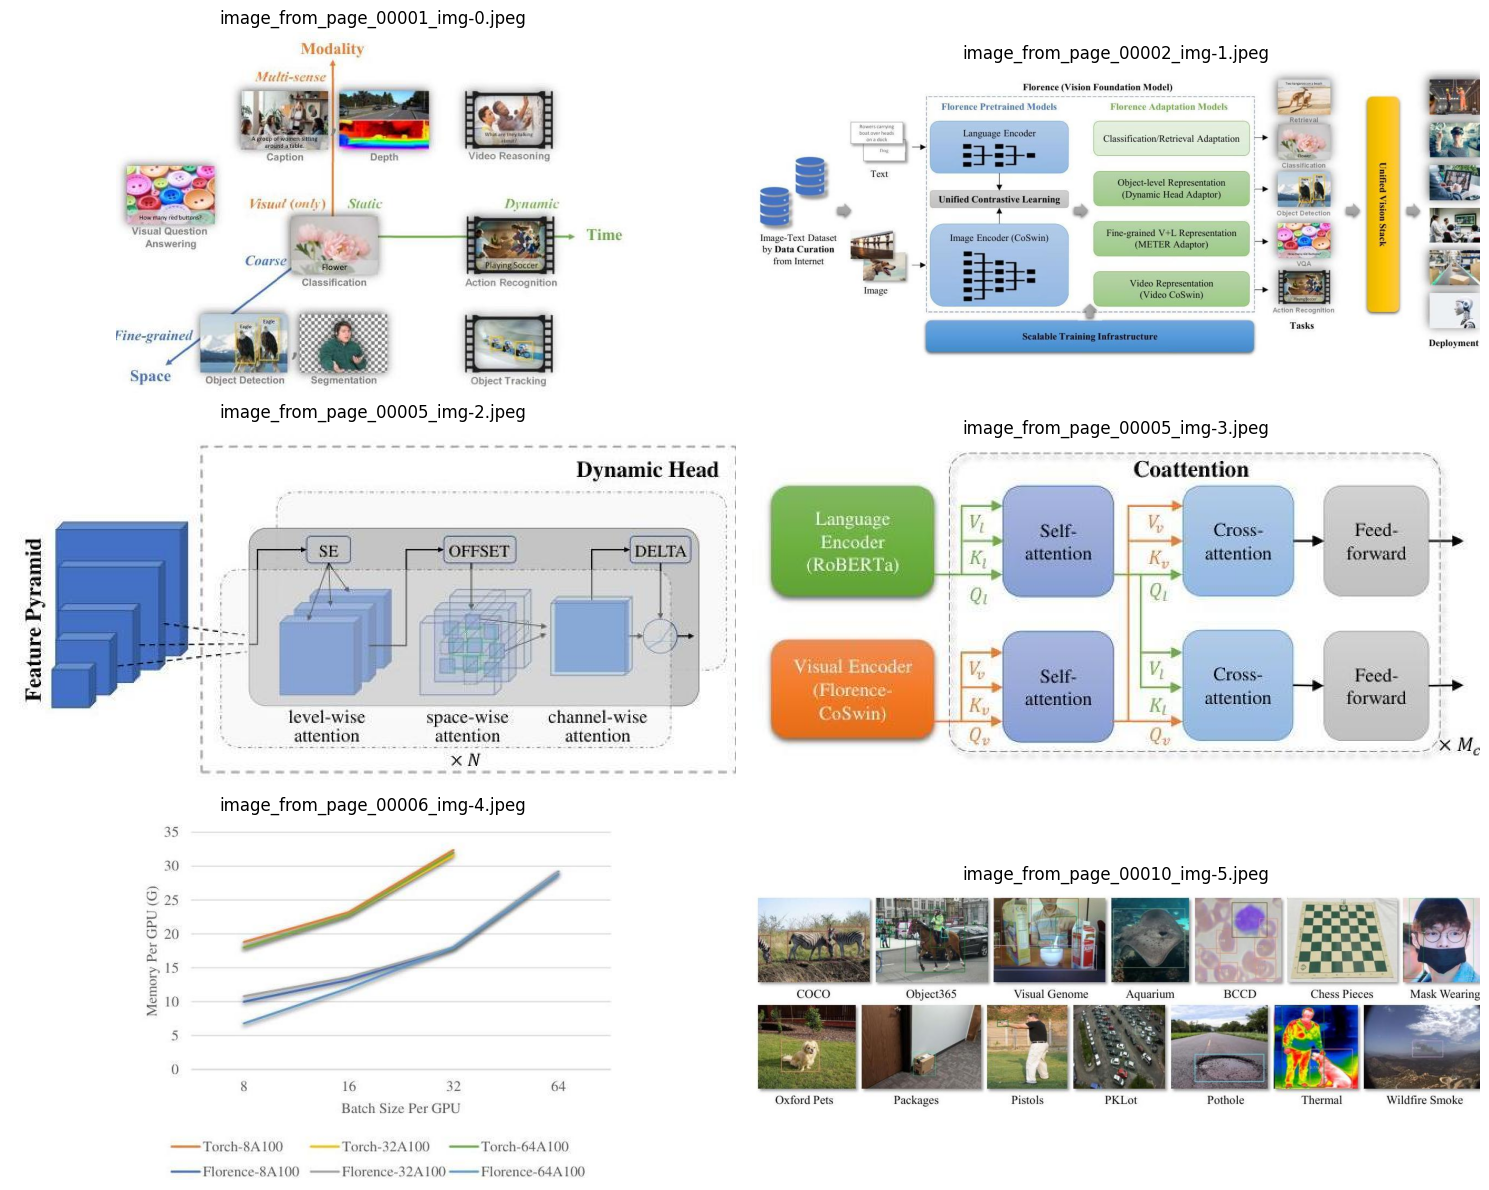

In [32]:
display_images("extracted_images", images_list, cols=2)

## 4. Images descriptions

In [33]:
def images_descriptions(
    document_path: str,
) -> Optional[Dict[Any, Any]]:
    """
    Process a document using AI to extract descriptions and hashtags.
    
    Args:
        document_path (str): Path to the document file
        api_key (str): API key for authentication
        endpoint (str): API endpoint URL
        model (str): Model to use for processing (default: mistral-document-ai-2505)
    
    Returns:
        Optional[Dict]: API response containing extracted information, or None if error
    """
    
    def encode_document(file_path: str) -> Optional[str]:
        """Encode document file to base64 string."""
        try:
            with open(file_path, "rb") as document_file:
                return base64.b64encode(document_file.read()).decode("utf-8")
        except FileNotFoundError:
            print(f"Error: The file {file_path} was not found.")
            return None
        except Exception as e:
            print(f"Error encoding file {file_path}: {e}")
            return None
    
    # Encode the document
    encoded_document = encode_document(document_path)
    if encoded_document is None:
        return None
    
    # Set up headers
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {key}",
    }
    
    # Create payload
    payload = {
        "model": "mistral-document-ai-2505",
        "document": {
            "type": "document_url",
            "document_url": f"data:application/pdf;base64,{encoded_document}",
        },
        "include_image_base64": "true",
        "bbox_annotation_format": {
            "type": "json_schema",
            "json_schema": {
                "name": "document_analysis",
                "description": "Extract descriptions and hashtags from document",
                "schema": {
                    "properties": {
                        "short_description": {
                            "description": "A short description in english describing the image.",
                            "title": "Short Description",
                            "type": "string",
                        },
                        "long_description": {
                            "description": "A long description in english describing the image.",
                            "title": "Long Description",
                            "type": "string",
                        },
                        "hashtags": {
                            "description": "Generate some hashtags to describe the image.",
                            "title": "hashtags",
                            "type": "string",
                        },
                    }
                },
            },
        },
    }
    
    try:
        # Make API request
        response = requests.post(
            url=endpoint,
            json=payload,
            headers=headers,
        )
        
        # Check if request was successful
        response.raise_for_status()
        
        return response.json()
        
    except requests.exceptions.RequestException as e:
        print(f"Error making API request: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error: {e}")
        return None


In [34]:
result = images_descriptions(document_path=pdf_file)

In [35]:
print("\033[1;31;34m")
for page in result["pages"]:
    page_index = page["index"]
    for image in page["images"]:
        image_annotation = json.loads(image["image_annotation"])
        print(f"Image in page: {page_index+1}\n")
        print(f"  📝 Short description: {image_annotation['properties']['short_description']}\n")
        print(f"  📖 Long description: {image_annotation['properties']['long_description']}\n")
        print(f"  🏷️ Hashtags: {image_annotation['properties']['hashtags']}\n")
        print("*" * 150)
        print()


Image in page: 1

  📝 Short description: {'description': 'A diagram illustrating various tasks and modalities in computer vision and image processing.', 'title': 'Short Description', 'type': 'string'}

  📖 Long description: {'description': 'The image is a detailed diagram that categorizes different tasks and modalities in the field of computer vision and image processing. It is divided into sections based on modality (multi-sense and visual), type (static and dynamic), and granularity (coarse and fine-grained). The multi-sense modality includes tasks like captioning, depth estimation, and video reasoning. The visual modality is further divided into static and dynamic categories. Static tasks include classification, object detection, and segmentation, while dynamic tasks include action recognition and object tracking. The diagram also shows examples of each task, such as a group of women sitting at a table for captioning, a depth map of a road for depth estimation, a flower for classif

### 5. Document informations

In [36]:
payload = {
    "model": "mistral-document-ai-2505",
    "pages": [0, 1, 2, 3, 4,],
    "document": {
        "type": "document_url",
        "document_url": f"data:application/pdf;base64,{encode_pdf(pdf_file)}",
    },
    "include_image_base64": "true",
    "document_annotation_format": {
        "type": "json_schema",
        "json_schema": {
            "name": "string",
            "description": "string",
            "schema": {
                "properties": {
                    "language": {
                        "title": "language",
                        "type": "string",
                        "description": "Display the language of the document.",
                    },
                    "document_date": {
                        "title": "document_date",
                        "type": "string",
                        "description": "Display the date of the document",
                    },
                    "classification": {
                        "title": "classification",
                        "type": "string",
                        "description": "Classify this document into: ART, POLITICS, AI, SPORTS, ECONOMY",
                    },
                    "summary": {
                        "title": "summary",
                        "type": "string",
                        "description": "Generate and display a brief summary of the document in English.",
                    },
                    "chapter_titles": {
                        "title": "chapter_titles",
                        "type": "string",
                        "description": "Display the titles of the chapters in the document.",
                    },
                    "keywords": {
                        "title": "keywords",
                        "type": "string",
                        "description": "Generate some keywords to describe the document",
                    },
                },
            },
        },
    },
}

headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {key}",
}

In [37]:
results = requests.post(
    url=endpoint,
    json=payload,
    headers=headers,
)

In [38]:
res = json.loads(results.json()["document_annotation"])

print("\033[1;31;34m")
print(f"🌐 Document language: {res['properties']['language']}\n")
print(f"🗂️ Document classification: {res['properties']['classification']}\n")
print(f"📅 Document date: {res['properties']['document_date']}\n")
print(f"📝 Document summary: {res['properties']['summary']}\n")
print(f"📚 Chapter titles: {res['properties']['chapter_titles']}\n")
print(f"🌍 Tags: {res['properties']['keywords']}\n")


🌐 Document language: English

🗂️ Document classification: AI

📅 Document date: 22 Nov 2021

📝 Document summary: The document presents Florence, a new foundation model for computer vision. It discusses the need for computer vision models to generalize well with minimal customization, similar to human vision. The paper introduces Florence to expand representations from coarse to fine, static to dynamic, and RGB to multiple modalities. Florence is trained on a diverse, large-scale dataset and can be adapted to various downstream tasks such as classification, retrieval, object detection, VQA, image caption, video retrieval, and action recognition. It demonstrates outstanding performance in transfer learning and achieves state-of-the-art results in numerous benchmarks. The document also outlines the ecosystem of constructing Florence, including data curation, model pretraining, task adaptations, and training infrastructure.

📚 Chapter titles: ['Abstract', '1. Introduction', '2. Approach', 